In [1]:
# standard python utilities
import os
import sys
from os.path import basename, dirname, join, exists, expanduser
import glob
import pandas as pd
import numpy as np
import time
from scipy.stats import gmean

# standard geospatial python utilities
import geopandas as gpd
from osgeo import gdal
import rasterio

# import flopy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
# statistics functions
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import datasets, linear_model
from scipy.stats import pearsonr, spearmanr, kendalltau


In [3]:
usr_dir = expanduser('~')
doc_dir = join(usr_dir, 'Documents')
# dir of all gwfm data
gwfm_dir = dirname(doc_dir)+'/Box/research_cosumnes/GWFlowModel'
# dir of stream level data for seepage study
proj_dir = gwfm_dir + '/Oneto_Denier/'
dat_dir = proj_dir+'Stream_level_data/'

sfr_dir = gwfm_dir+'/SFR_data/'

In [4]:
out_dir = join(proj_dir, 'output')
fig_dir = join(proj_dir, 'figures')

In [5]:
flopy_dir = doc_dir+'/GitHub/flopy'
if flopy_dir not in sys.path:
    sys.path.insert(0, flopy_dir)
    
import flopy 

In [119]:
ext_dir = 'F:/WRDAPP'
c_dir = 'C:/WRDAPP'
if os.path.exists(ext_dir):
    loadpth = ext_dir 
elif os.path.exists(c_dir):
    loadpth = c_dir 
loadpth +=  '/GWFlowModel/Cosumnes/Stream_seepage'

upscale = 4 
upscale_txt = 'upscale'+str(upscale)+'x_'
# model_nam = 'inset_oneto_denier'
model_nam = 'oneto_denier_'+upscale_txt+'2014_2018'

base_model_ws = join(loadpth,model_nam)

# all_model_ws = join(loadpth, 'parallel_oneto_denier')
all_model_ws = join(loadpth, 'parallel_'+model_nam)

# may want to skip loading rch, evt and wel which take up a lot of memory with stress period data
load_only = ['DIS','UPW','SFR','OC']
m = flopy.modflow.Modflow.load('MF.nam', model_ws= base_model_ws, 
                                exe_name='mf-owhm.exe', version='mfnwt')


In [120]:
homogeneous_ws = join(loadpth, 'oneto_denier_homogeneous_2014_2018')


In [121]:
m_ver = ''

In [122]:
grid_dir = join(gwfm_dir, 'DIS_data/streambed_seepage/grid')
grid_fn = join(grid_dir, 'inset_oneto_denier','rm_only_grid.shp')
grid_p = gpd.read_file(grid_fn)
grid_p.crs='epsg:32610'
m_domain = gpd.GeoDataFrame(pd.DataFrame([0]), geometry = [grid_p.unary_union], crs=grid_p.crs)

In [123]:
XSg = pd.read_csv(join(base_model_ws,'04_XSg_filled.csv'))
XSg = gpd.GeoDataFrame(XSg, geometry = gpd.points_from_xy(XSg.Easting, XSg.Northing), crs='epsg:32610')

drop_iseg = XSg[~XSg['Logger Location'].isna()].iseg.values
# overwrite SFR segment/reach input relevant to seepage
# sensor_dict = pd.read_csv(join(model_ws, 'sensor_xs_dict.csv'), index_col=0)
# XS_params = sensor_dict.join(params.set_index('Sensor'), on='Sensor')

In [124]:
grid_sfr_all = pd.DataFrame()
for r in np.arange(0,100): #100
    folder = 'realization'+ str(r).zfill(3)
    # update model workspace so outputs to right directory
    model_ws = join(all_model_ws, folder)
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv',index_col=0)
    grid_sfr = grid_sfr.drop(columns=['node','geometry','node.1'])
    grid_p_sfr = grid_p.set_index(['row','column']).loc[list(zip(grid_sfr.i+1,grid_sfr.j+1))].reset_index(drop=True)
    grid_sfr = pd.concat((grid_p_sfr,grid_sfr),axis=1)
    grid_sfr_all = pd.concat((grid_sfr_all, grid_sfr.assign(realization=r)))
grid_sfr_all = grid_sfr_all[~grid_sfr_all.iseg.isin(drop_iseg)]

In [125]:
sfrdf = pd.DataFrame(m.sfr.reach_data)
grid_sfr = grid_p.set_index(['row','column']).loc[list(zip(sfrdf.i+1,sfrdf.j+1))].reset_index(drop=True)
grid_sfr = pd.concat((grid_sfr,sfrdf),axis=1)

# characterize streambed into different hydrofacies
tprogs_quants = np.array([0.590, 0.155, 0.197, 0.058]).cumsum()
vka_quants = grid_sfr.strhc1.quantile(tprogs_quants)
vka_quants.index=['mud','sandy mud','sand','gravel']
grid_sfr['facies'] = 'mud'
for n in np.arange(0,len(vka_quants)-1):
    grid_sfr.loc[grid_sfr.strhc1 > vka_quants.iloc[n],'facies'] = vka_quants.index[n+1]

# add color for facies plots
gel_color = pd.read_csv(join(gwfm_dir,'UPW_data', 'mf_geology_color_dict.csv'), comment='#')
gel_color.geology = gel_color.geology.str.lower()
grid_sfr = grid_sfr.join(gel_color.set_index('geology')[['color']], on='facies')
# remove stream segments for routing purposes only
grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]

In [126]:
strt_date = pd.to_datetime(m.dis.start_datetime)
end_date = (strt_date + pd.Series(m.dis.perlen.array.sum()).astype('timedelta64[D]'))[0]
# with SS period near 0 no longer minus one
dates_per = strt_date + (m.dis.perlen.array.cumsum()).astype('timedelta64[D]')
stplen = m.dis.perlen.array/m.dis.nstp.array
# astype timedelta64 results in save days
hrs_from_strt = ((np.append([0], np.repeat(stplen, m.dis.nstp.array)[:-1])).cumsum()*24).astype('timedelta64[h]')
dates_stps = strt_date + hrs_from_strt

# get ALL stress periods and time steps list, not just those in the output
kstpkper = []
for n,stps in enumerate(m.dis.nstp.array):
    kstpkper += list(zip(np.arange(0,stps),np.full(stps,n)))

dt_ref = pd.DataFrame(dates_stps, columns=['dt'])
dt_ref['kstpkper'] = kstpkper

# Obs checking

In [127]:
def nse(targets,predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(predictions))**2))

# hob metadata
rm_grid = pd.read_csv(join(proj_dir, 'mw_hob_cleaned.csv'))


In [128]:
def clean_hob(model_ws):
    hobout = pd.read_csv(join(model_ws,'MF.hob.out'),delimiter=r'\s+', header = 0,names = ['sim_val','obs_val','obs_nam'],
                         dtype = {'sim_val':float,'obs_val':float,'obs_nam':object})
    hobout[['Sensor', 'spd']] = hobout.obs_nam.str.split('p',n=2, expand=True)
    hobout['kstpkper'] = list(zip(np.full(len(hobout),0), hobout.spd.astype(int)))
    hobout.loc[hobout.sim_val.isin([-1e30, -999.99,-9999]), 'sim_val'] = np.nan
    hobout = hobout.dropna(subset='sim_val')
    hobout = hobout.join(dt_ref.set_index('kstpkper'), on='kstpkper')
    hobout['error'] = hobout.obs_val - hobout.sim_val
    hobout['sq_error'] = hobout.error**2
    return(hobout)

In [129]:
# 
sum_stats = pd.DataFrame(columns=['r2','RMSE','NSE'], dtype=np.float64)
mw_stats = pd.DataFrame(columns=['realization','SOSE','RMSE','NSE'], dtype=np.float64)
hob_err_chk = pd.DataFrame()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    hobout = clean_hob(model_ws)
    # removing oneto ag because of large depth offset
    hobout = hobout[hobout.Sensor != 'MW_OA']
    hob_3m = hobout.set_index('dt').groupby('Sensor').resample('3MS').mean(numeric_only=True).reset_index('dt')
    hob_err_chk = pd.concat((hob_err_chk, hob_3m.groupby('dt').mean()))
    # summary stats by well
    mw_stats['realization'] = t
    for s in hobout.Sensor.unique():
        df_s = hobout[hobout.Sensor==s]
        mw_stats.loc[s,'SOSE'] = hobout[['Sensor','sq_error']].groupby('Sensor').sum()
        mw_stats.loc[s,'r2'] = r2_score(df_s.obs_val, df_s.sim_val)
        mw_stats.loc[s,'RMSE'] = mean_squared_error(df_s.obs_val, df_s.sim_val, squared=True)
        mw_stats.loc[s,'NSE'] = nse(df_s.obs_val, df_s.sim_val)

    # summary statistics
    sum_stats.loc[t,'r2'] = r2_score(hobout.obs_val, hobout.sim_val)
    sum_stats.loc[t,'RMSE'] = np.sqrt(hobout.sq_error.sum()/len(hobout))
    sum_stats.loc[t,'NSE'] = nse(hobout.obs_val, hobout.sim_val)


In [130]:
# filter out realizations who haven't finished running yet
stats_done = sum_stats[sum_stats.NSE!=sum_stats.NSE.min()].copy()

In [131]:
stats_done.to_csv(join(out_dir, 'hob_fit_stats.csv'))


<Axes: >

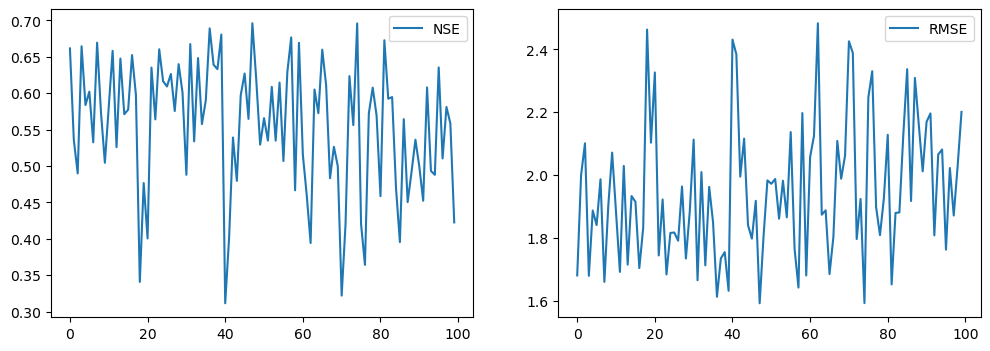

In [132]:
# review to see if error is generally similar between realizations
# review hydrographs for realization with worst error
fig,ax = plt.subplots(1,2, figsize=(12,4))
stats_done.plot(y='NSE', ax=ax[0])
stats_done.plot(y='RMSE', ax=ax[1])


In [133]:
# identify the 10 realizations with the best accuracy
# calculate best score, r2 is tiebreak
stats_done['score'] = (stats_done.NSE >= stats_done.NSE.quantile([0.9]).values[0]).astype(float)
stats_done.score += (stats_done.RMSE <= stats_done.RMSE.quantile([0.1]).values[0]).astype(float)
stats_done.score += (stats_done.r2 >= stats_done.r2.quantile([0.9]).values[0]).astype(float)*0.25
# pull 10 best realizations 
best_realizations = stats_done[stats_done.score >= stats_done.score.quantile([0.9]).values[0]]
print('best realizations', best_realizations.index)
best_realizations.to_csv(join(proj_dir,upscale_txt+'top_10_accurate_realizations.csv'))


best realizations Index([3, 7, 31, 36, 39, 47, 57, 59, 74, 81], dtype='int64')


<Axes: title={'center': 'error'}, xlabel='year'>

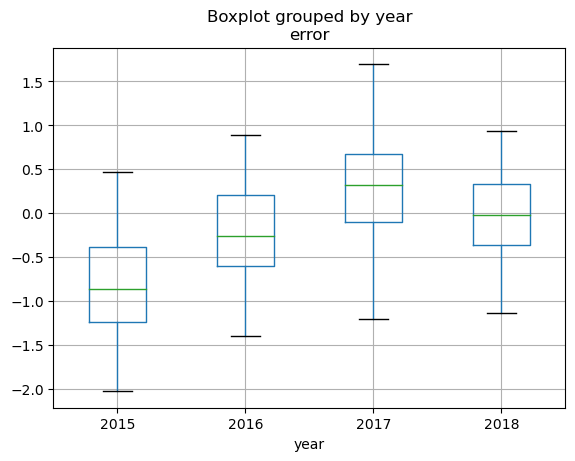

In [134]:
# it seems like in the summer the average error is -1 to -2.75 m with it more sever in the drought

hob_err_chk = hob_err_chk.assign(month=hob_err_chk.index.month, year = hob_err_chk.index.year)
hob_err_chk[hob_err_chk.month==7].boxplot(by='year', column='error')

In [257]:
# check hydrographs with worst error
# t = sum_stats['RMSE'].idxmax()
t = sum_stats['RMSE'].idxmin()
# approximate median location
# t = sum_stats.sort_values('RMSE').iloc[int(len(sum_stats)/2)].name
# t=11
# t = 45
print(t)
print(sum_stats.loc[t])
def mak_hob_long(t):
    hobout = clean_hob(join(all_model_ws, 'realization'+ str(t).zfill(3)))
    # removing oneto ag because of large depth offset
    hobout = hobout[hobout.Sensor != 'MW_OA']
    hob_long = hobout.melt(id_vars=['dt', 'Sensor'],value_vars=['sim_val','obs_val'], value_name='gwe')
    return(hob_long)
hob_long = mak_hob_long(t)
# hob_long

47
r2      0.695973
RMSE    1.592564
NSE     0.696112
Name: 47, dtype: float64


In [271]:
hob_h = clean_hob(homogeneous_ws)
t = sum_stats['RMSE'].idxmin()
hob_min = clean_hob(join(all_model_ws, 'realization'+ str(t).zfill(3)))
t=sum_stats['RMSE'].idxmax()
hob_max = clean_hob(join(all_model_ws, 'realization'+ str(t).zfill(3)))
t= sum_stats.sort_values('RMSE').iloc[int(len(sum_stats)/2)].name
hob_med = clean_hob(join(all_model_ws, 'realization'+ str(t).zfill(3)))


In [278]:
cols = ['dt', 'sim_val','Sensor']
hob_comp = pd.concat((
    hob_med[cols].assign(var='Median'),
    hob_max[cols].assign(var='Max'),
    hob_min[cols].assign(var='Min'),
    hob_h[cols].assign(var='Homogeneous'),
    hob_h[['dt','obs_val','Sensor']].rename(columns={'obs_val':'sim_val'}).assign(var='Observations')
    ))


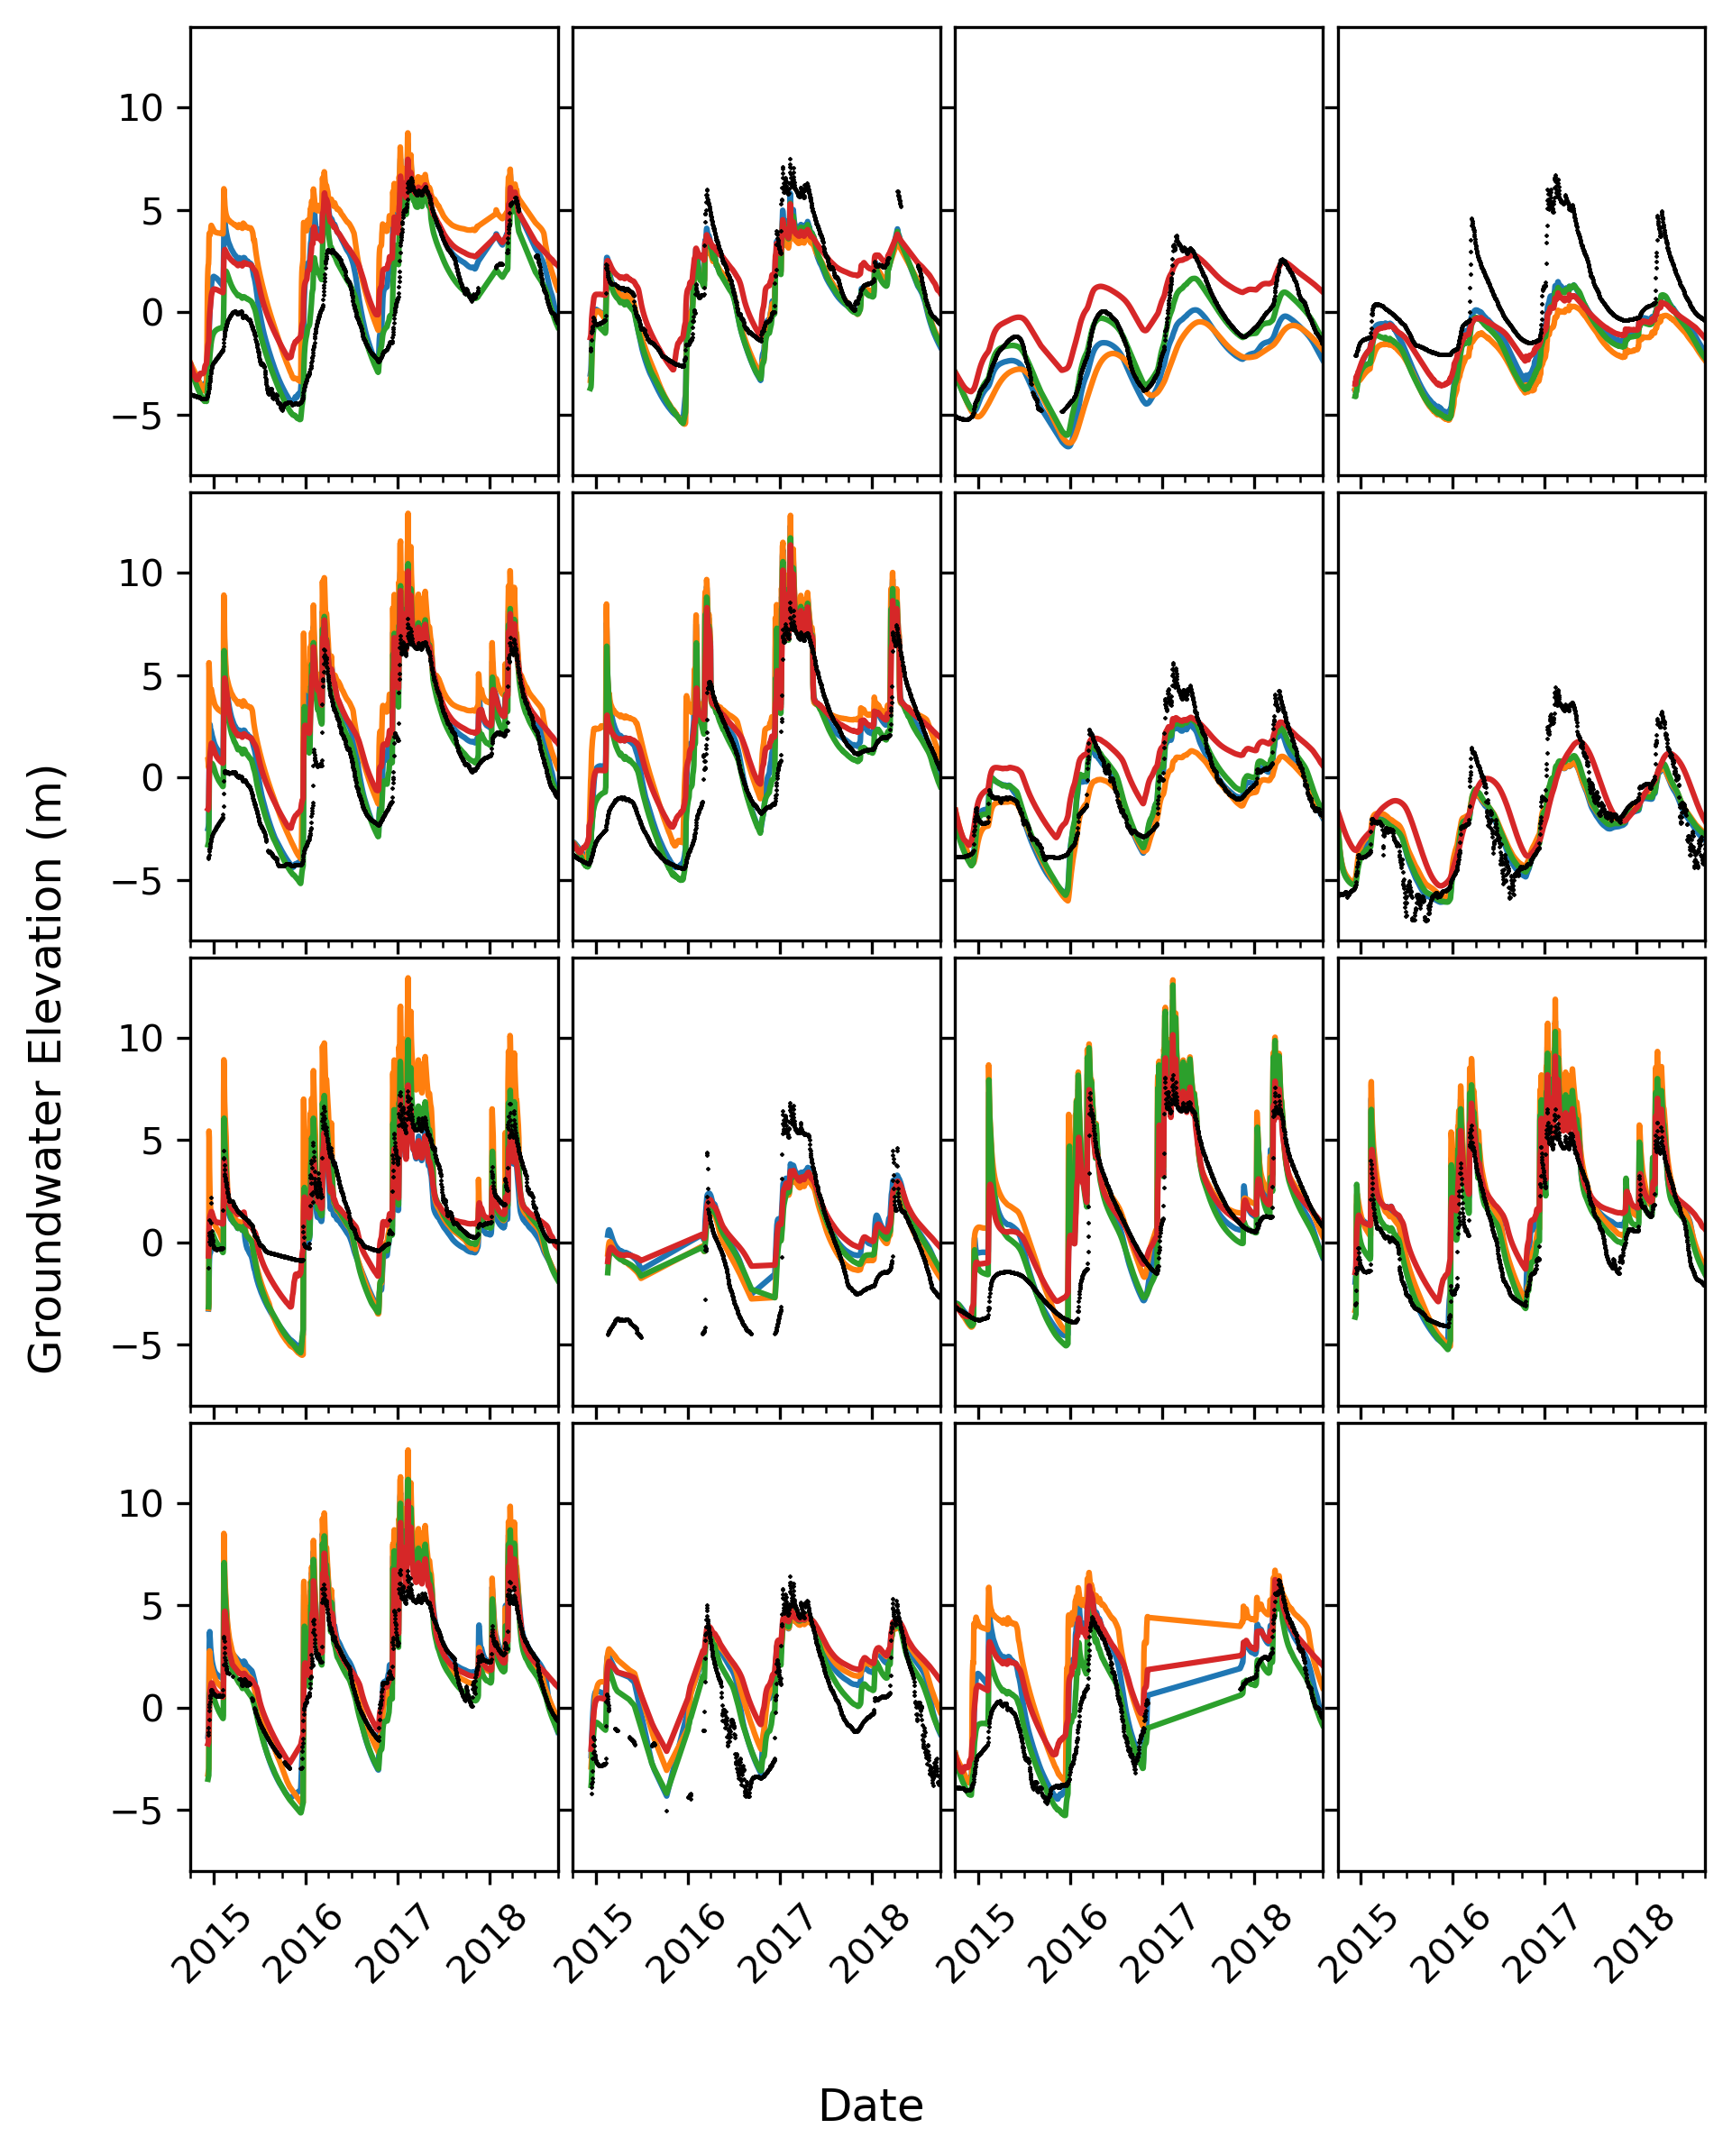

In [314]:
nx=4
wells = hob_med.Sensor.unique()
ny = int(np.round(len(wells)/nx))
fig,ax = plt.subplots(4,4, sharex=True, sharey=True, figsize=(6.5, 8), dpi=300)
for n, w in enumerate(wells):
    ax_n = ax[int(n/ny), n%ny]
    hob_med[hob_med.Sensor==w].plot(x='dt',y='sim_val', ax=ax_n, legend=False)
    hob_max[hob_max.Sensor==w].plot(x='dt',y='sim_val', ax=ax_n, legend=False)
    hob_min[hob_min.Sensor==w].plot(x='dt',y='sim_val', ax=ax_n, legend=False)
    hob_h[hob_h.Sensor==w].plot(x='dt',y='sim_val', ax=ax_n, legend=False)
    hob_h[hob_h.Sensor==w].plot(x='dt',y='obs_val', ax=ax_n, legend=False, marker='x', linestyle='', color='black',markersize=0.5)
fig.supylabel('Groundwater Elevation (m)')
fig.supxlabel('Date')

fig.tight_layout(h_pad=0.1, w_pad=-0.5)

for n in np.arange(0,nx):
    ax_n = ax[-1,n]
    ax_n.set_xlabel(None)
    ax_n.set_xticks(pd.date_range(strt_date, end_date, freq='AS'), 
                         pd.date_range(strt_date, end_date, freq='AS').year.astype(str).values, rotation=45)
    ax_n.set_xticks(pd.date_range(strt_date, end_date, freq='3MS'), minor=True)

In [315]:
# in the wrost case the dynamics match but the magnitude is off (levels start much too low)
# import seaborn as sns
# g = sns.relplot(hob_long, x='dt',y='gwe',col='Sensor',hue='variable', col_wrap=4);



In [137]:
gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

def read_gage(gagenam):
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = r'\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    strt_date = pd.to_datetime(m.dis.start_datetime)
    gage['dt'] = strt_date+(gage.Time*24).astype('timedelta64[h]')
    gage = gage.set_index('dt')
    gage['dVolume'] = gage.Volume.diff()
    gage['Total_In'] = gage[['Precip.','Runoff','GW-Inflw','SW-Inflw']].sum(axis=1)
    gage['Total_Out'] = gage[['Evap.','Withdrawal','GW-Outflw','SW-Outflw']].sum(axis=1)
    gage['In-Out'] = gage.Total_In - gage.Total_Out
#     gage['name'] = run
    return(gage)


## Water Budget check

In [138]:
# manual columns
wb_out_cols  =['WEL_OUT','ET_OUT','GHB_OUT','SFR_OUT','LAK_OUT']
wb_in_cols = ['RCH_IN','GHB_IN','SFR_IN','LAK_IN']

In [139]:
wb_all = pd.DataFrame()
for t in np.arange(0,100):
    model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
    # load summary water budget
    wb = pd.read_csv(model_ws+'/flow_budget.txt', delimiter=r'\s+')
    # wb = pd.read_csv(loadpth+'/oneto_denier_upscale8x_2014_2018'+'/flow_budget.txt', delimiter=r'\s+')
    wb['kstpkper'] = list(zip(wb.STP-1,wb.PER-1))
    wb = wb.merge(dt_ref, on='kstpkper')
    wb['realization'] = t
    wb_all = pd.concat((wb_all, wb))


In [191]:
# wb_plt.mean(axis=1)
# need to update homogeneous run for layering and
wb_h = pd.read_csv(homogeneous_ws+'/flow_budget.txt', delimiter=r'\s+')
wb_h['kstpkper'] = list(zip(wb_h.STP-1,wb_h.PER-1))
wb_h = wb_h.merge(dt_ref, on='kstpkper')

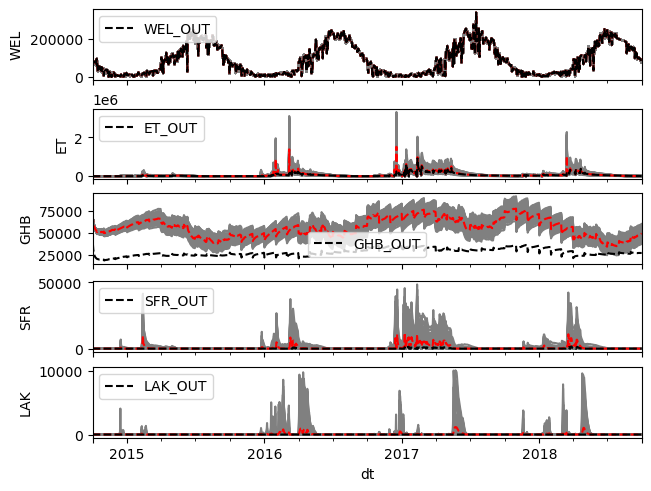

In [192]:
fig,ax = plt.subplots(5,1, sharex=True, layout='constrained')
for n, wb_n in enumerate(wb_out_cols):
    wb_plt = wb_all.pivot_table(index='dt',columns='realization',values=wb_n)
    wb_plt.plot(legend=False, color='gray', ax=ax[n]) 
    wb_plt.mean(axis=1).plot(color='red',linestyle='--',ax=ax[n])
    wb_h.plot(x='dt', y=wb_out_cols[n], color='black',linestyle='--',ax=ax[n])
    ax[n].set_ylabel(wb_out_cols[n].split('_')[0])

<Axes: >

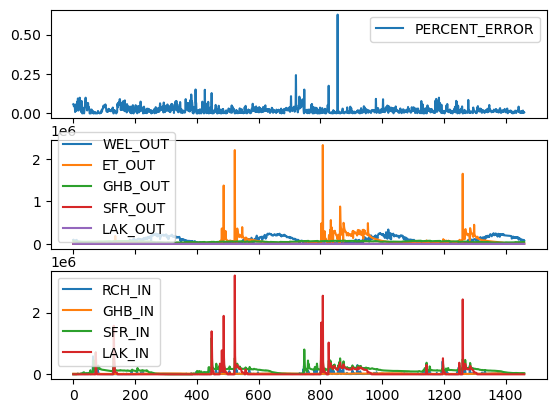

In [142]:
wb_chk_plt = wb_all[wb_all.realization==t]
fig,ax= plt.subplots(3,1, sharex=True)
wb_chk_plt.plot(y='PERCENT_ERROR', ax=ax[0])
wb_chk_plt.plot(y=wb_out_cols, ax=ax[1], legend=True)
wb_chk_plt.plot(y=wb_in_cols, ax=ax[2], legend=True)

# Stream seepage plots

In [189]:
rewrite = False
# rewrite = True

In [144]:
# pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
# pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()

def clean_sfr_df(model_ws, drop_iseg):
    ## load sfr reach data ##
    grid_sfr = pd.read_csv(model_ws+'/grid_sfr.csv')
    # remove stream segments for routing purposes only
    grid_sfr = grid_sfr[~grid_sfr.iseg.isin(drop_iseg)]
    pd_sfr = grid_sfr.set_index(['iseg','ireach'])[['rchlen','strtop', 'facies', 'color']]
    pd_sfr['Total distance (m)'] = pd_sfr['rchlen'].cumsum()
    num_coarse = int(grid_sfr.facies.isin(['Gravel','Sand']).sum())
    
    ## load sfr out file ##
    sfrout = flopy.utils.SfrFile(join(model_ws, m.name+m_ver+'.sfr.out'))
    sfrdf = sfrout.get_dataframe()
    sfrdf = sfrdf.join(dt_ref.set_index('kstpkper'), on='kstpkper').set_index('dt')
    # convert from sub-daily to daily using mean, lose kstpkper
    sfrdf = sfrdf.groupby('segment').resample('D').mean(numeric_only=True)
    sfrdf = sfrdf.reset_index('segment', drop=True)
    sfrdf[['row','column']] = sfrdf[['row','column']].astype(int) - 1 # convert to python
    
    ## join sfr out to reach data ##
    sfrdf = sfrdf.join(pd_sfr ,on=['segment','reach'],how='inner',lsuffix='_all')
    sfrdf['num_coarse'] = num_coarse
    
    ## data transformation for easier manipulation ##
    sfrdf['month'] = sfrdf.index.month
    sfrdf['WY'] = sfrdf.index.year
    sfrdf.loc[sfrdf.month>=10, 'WY'] +=1
    # create column to calculate days flowing
    sfrdf['flowing'] = 1
    sfrdf.loc[sfrdf.Qout <= 0, 'flowing'] = 0
    
    # create different column for stream losing vs gaining seeapge
    sfrdf['Qrech'] = np.where(sfrdf.Qaquifer>0, sfrdf.Qaquifer,0)
    sfrdf['Qbase'] = np.where(sfrdf.Qaquifer<0, sfrdf.Qaquifer*-1,0 )
    # booleans for plotting
    sfrdf['gaining'] = (sfrdf.gradient <= 0)
    sfrdf['losing'] = (sfrdf.gradient >= 0)
    sfrdf['connected'] = (sfrdf.gradient < 1)
    return(sfrdf)



In [200]:
sfrdf =  clean_sfr_df(base_model_ws, drop_iseg)
h_sfrdf =  clean_sfr_df(homogeneous_ws, drop_iseg)


In [146]:
# standardize grouping values
wy_vals = sfrdf.WY.unique()
facies_vals = ['Mud','Sandy Mud','Sand','Gravel']


# Aggregate stream data
1. Aggregate across all segments  but save all dates
2. Aggregate across dates but save all segments


## Gradient plots (spatial)
1. Seepage averaged across the year (or between dry and wet season) and the rows could be realizations instead which would help indicate consistency across realizations  
2. Heat map of columns with stream segments, rows of dates and the color blue to red for gaining or losing with the seepage averaged across all realizations

When the gradient is greater than 1 we know we have disconnected conditions, I need to represent the count of days where the system is connected.
- Since I've focused more baseflow/seepage and streamflow/flowing days the connected/gaining gradient plots tend to repeat the information on baseflow/seepage and are usual lower correlations because they are slightly less impacted by the coarse vs fine conductivity.

In [147]:
if rewrite:
    # aggregate data by facies and sum to review seepage over time
    t0 = time.time()

    sfr_facies_all = pd.DataFrame()
    for t in np.arange(0,100):
        model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
        # remove stream segments for routing purposes
        sfrdf =  clean_sfr_df(model_ws, drop_iseg)
        # summing by facies makes sense for seepage
        sfr_facies_sum = sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
        sfr_facies_sum['realization'] = t
        # count number of facies if needed later for explaining rates
        sfr_facies_sum['num_facies'] = sfrdf.groupby(['dt','facies']).count().iloc[:,0].values
        sfr_facies_all = pd.concat((sfr_facies_all, sfr_facies_sum))
    # check time
    t1 = time.time()
    print('Time: %.2f min' % ((t1-t0)/60))
    # save output to speed up reuse
    # sfr_facies_all.to_csv(join(out_dir, 'sfrdf_facies_sum.csv'))
    sfr_facies_all.reset_index(level='facies').to_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'), key='dt', complevel=4)

Time: 10.32 min


In [148]:
sfr_facies_all = pd.read_hdf(join(out_dir, 'sfrdf_facies_sum.hdf5'))
# sfr_facies_all = sfr_facies_all.set_index('facies', append=True)

In [149]:
# fig,ax = plt.subplots()

# days connected
# df_plt = sfrdf.groupby('segment').sum(numeric_only=True)[['connected']]
# ax_conn = df_plt.plot(legend=False)
# plt.ylabel('Connected Days')
# plt.xlabel('Segment')

# for f in sfrdf.facies.unique():
#     ax_conn.fill_between(sfrdf.segment, 0, df_plt.max(), where = sfrdf.facies==f,
#                     color=gel_color.loc[gel_color.geology==f,'color'], alpha=0.5)

## Notes
In these I need to clarify the proportion of the streambed (length or area) that is each facies to show that despite being only a small percent of the streambed sand and gravel make up a significant portion of recharge and baseflow. 

## Seepage plots (temporal)
Aggregate by facies to plot cumulative seepage (by time) to help show variability caused by geology.

In [150]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='gray', label='Heterogeneous\nRealizations'),
    Line2D([0], [0], color='black', linestyle='--',label='Homogeneous\nCase'),
    Line2D([0], [0], color='red', linestyle='--', label='Heterogeneous\nMean')
]


Despite being only a small percentage of the stream segments, the sand and gravel produce a significant portion of the stream seepage.

In [151]:
value = 'Qbase'
ylabel  = 'Baseflow ($m^3/d$)'
def plt_dt_facies(value, ylabel):
    # original plotting was 12 by8 but then text is very small
    fig,ax = plt.subplots(2,2, figsize=(8,5.3), sharex=True, sharey=True, layout='constrained')#
    facies = ['Mud','Sandy Mud','Sand','Gravel']
    for t in np.arange(0,100):
        sfr_facies_sum = sfr_facies_all[sfr_facies_all.realization==t]
        for n,f in enumerate(facies):
            ax_n = ax[int(n/2), n%2]
            df_plt = sfr_facies_sum[sfr_facies_sum.facies==f]
            if df_plt.shape[0]>0:
                df_plt.plot(y=value, ax=ax_n, legend=False, color='gray')
    # plot homogeneous case
    h_sfr_facies_sum = h_sfrdf.groupby(['dt','facies']).sum(numeric_only=True)
    # plot mean of heterogeneous
#     sfr_facies_mean = sfr_facies_all.groupby(['dt', 'facies','realization']).sum(numeric_only=True)
    sfr_facies_mean = sfr_facies_all.groupby(['dt', 'facies']).mean().reset_index('facies')
    # set axis labels
    for n,f in enumerate(facies):
        ax_n = ax[int(n/2), n%2]
        h_sfr_facies_sum.reset_index('facies').plot(y=value, ax=ax_n, legend=False, color='black', linestyle='--')
        sfr_facies_mean[sfr_facies_mean.facies==f].plot(y=value, ax=ax_n, legend=False, color='red', linestyle='--')
        ax_n.set_title(f)
        ax_n.set_yscale('log')
        ax_n.set_ylabel(ylabel)
        ax_n.set_xlabel('Date')
    # add figure legend
    fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)


In [152]:
# value = 'Qbase'
# plt_dt_facies(value, ylabel)
# ax.legend(handles=legend_elements, loc='lower right')


On an individual realization level the plots grouping baseflow by facies are interesting but on a whole they are not because among realizations there is enough variability to make patterns appear similar. 

In [153]:
# value = 'Qrech'
# ylabel  = 'Stream Seepage ($m^3/d$)'
# plt_dt_facies(value, ylabel)


## Streamflow
No need to aggregate by facies, instead show impact at downstream end in terms of time step and cumulative

In [154]:
if rewrite:
    sfr_last_all = pd.DataFrame()
    for t in np.arange(0,100):
        model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
        sfrdf =  clean_sfr_df(model_ws, drop_iseg)
        # plot from last segment (shows cumulative effects)
        sfr_last = sfrdf[sfrdf.segment==sfrdf.segment.max()].copy()
        sfr_last['realization'] = t
        sfr_last_all = pd.concat((sfr_last_all, sfr_last))

    # save data
    sfr_last_all.to_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'), key='dt', complevel=4)

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_111652\931486029.py:12: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->Index(['facies', 'color'], dtype='object')]

  sfr_last_all.to_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'), key='dt', complevel=4)


In [155]:
sfr_last_all = pd.read_hdf(join(out_dir, 'sfrdf_last_seg.hdf5'))

The plots of streambed seepage and streamflow at the outlet present the variability among realizations and provide context for the results we will interpret. They explain we have a dominantly losing system where the mangitude of seepage is shifted up or down due to heterogeneity and the streamflow is also shifted up or down but this is most noticeable during lower flows when seepage has a greater proportional impact on streamflow.  
- Plot the standard deviation among the results for year/season because this will show how far off a difference of heterogeneity can affect interpretation, e.g., if we don't include heterogeneity we might miss the magnitude of flow imapcts.

Time: 0.27 min


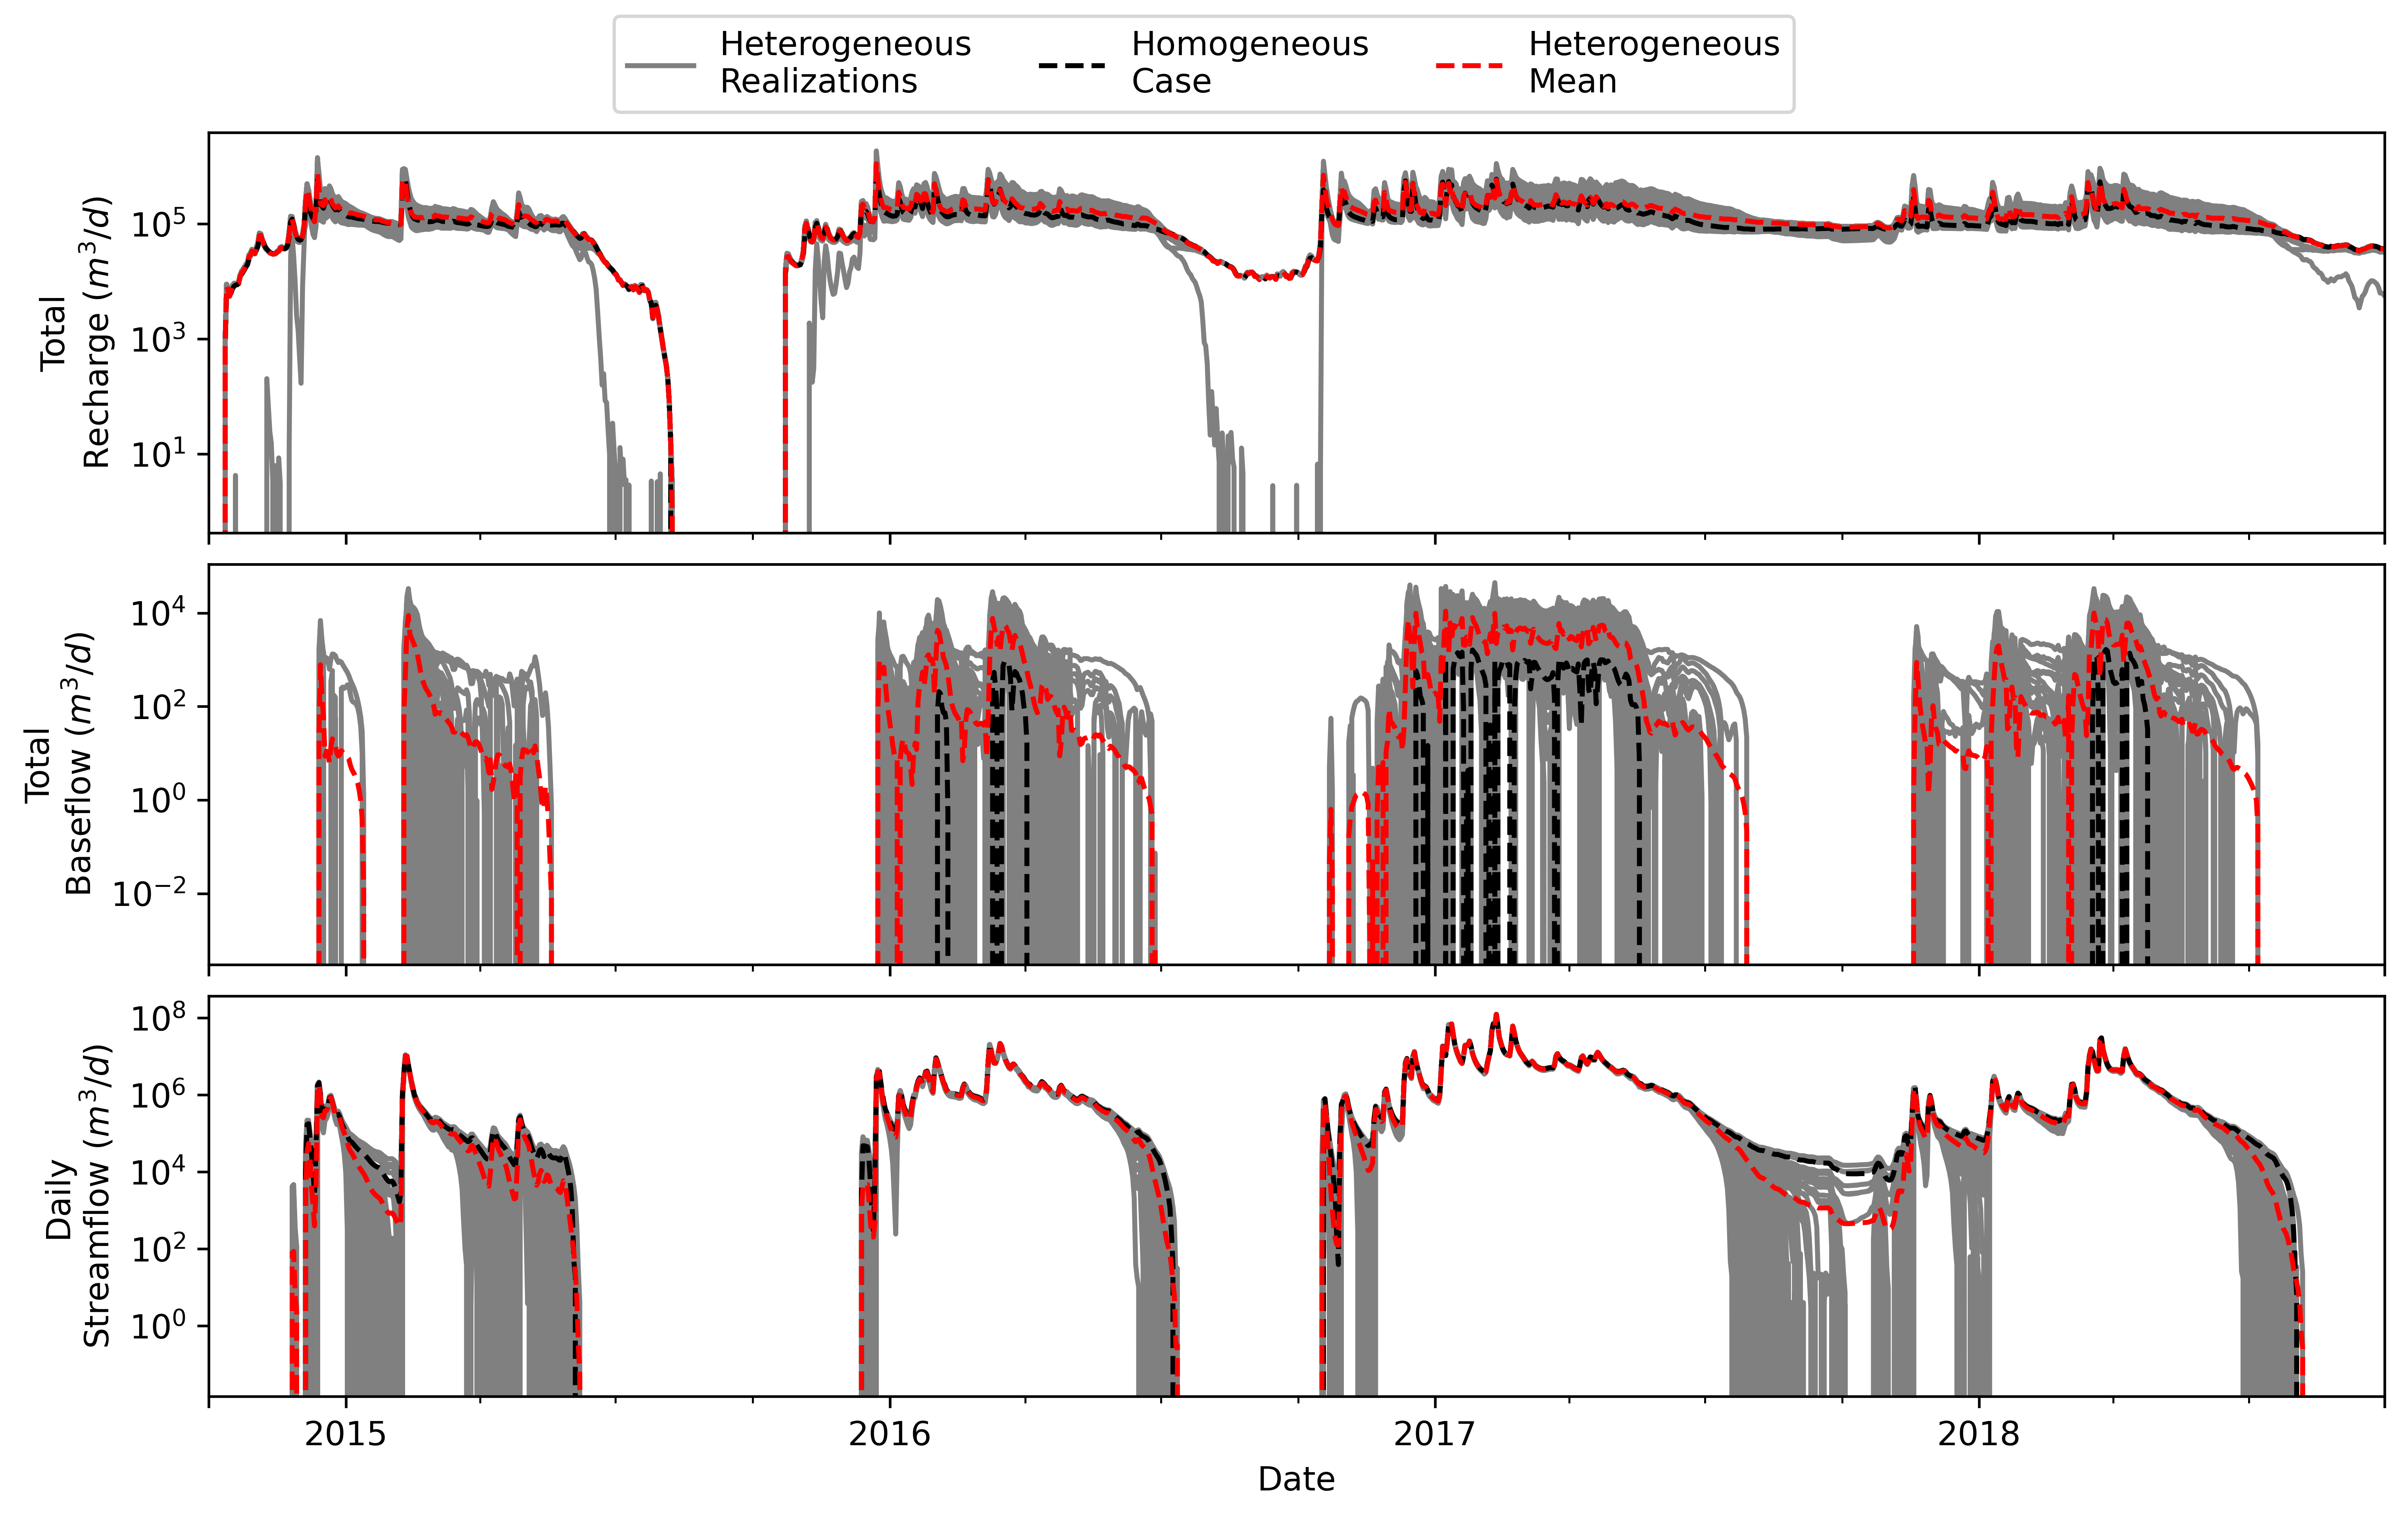

In [213]:
t0 = time.time()
fig,ax = plt.subplots(3,1, figsize=(10,6.3), sharex=True, sharey=False, layout='constrained',dpi=600)

for t in np.arange(0,100):
    sfr_last = sfr_last_all[sfr_last_all.realization==t]
    sfr_last.plot(y='Qin', ax=ax[-1], legend=False, color='gray')
    sfr_seg = sfr_facies_all[sfr_facies_all.realization==t].groupby('dt').sum(numeric_only=True)
    # sfr_seg.plot(y='Qaquifer', ax=ax[0], legend=False, color='gray')
    sfr_seg.plot(y='Qrech', ax=ax[0], legend=False, color='gray')
    sfr_seg.plot(y='Qbase', ax=ax[1], legend=False, color='gray')

# plot homogeneous case
h_sfr_last = h_sfrdf[h_sfrdf.segment==h_sfrdf.segment.max()]
h_sfr_last.plot(y='Qin', ax=ax[-1], legend=False, color='black',linestyle='--')
# h_sfrdf.groupby('dt').sum(numeric_only=True).plot(y='Qaquifer', ax=ax[0], legend=False, color='black', linestyle='--')
h_sfrdf.groupby('dt').sum(numeric_only=True).plot(y='Qrech', ax=ax[0], legend=False, color='black', linestyle='--')
h_sfrdf.groupby('dt').sum(numeric_only=True).plot(y='Qbase', ax=ax[1], legend=False, color='black', linestyle='--')
# plot mean of heterogeneous
sfr_last_mean = sfr_last_all.groupby('dt').mean(numeric_only=True)
sfr_last_mean.plot(y='Qin', ax=ax[-1], legend=False, color='red',linestyle='--')
sfr_sum_mean = sfr_facies_all.groupby(['dt', 'realization']).sum(numeric_only=True).groupby('dt').mean()
# sfr_sum_mean.plot(y='Qaquifer', ax=ax[0], legend=False, color='red', linestyle='--')
sfr_sum_mean.plot(y='Qrech', ax=ax[0], legend=False, color='red', linestyle='--')
sfr_sum_mean.plot(y='Qbase', ax=ax[1], legend=False, color='red', linestyle='--')

# set axis labels
ax[-1].set_xlabel('Date')
# ax[0].set_ylabel('Total Seepage ($m^3/d$)')
ax[0].set_ylabel('Total\nRecharge ($m^3/d$)')
ax[1].set_ylabel('Total\nBaseflow ($m^3/d$)')
ax[-1].set_ylabel('Daily\nStreamflow ($m^3/d$)')

# need log scale or peaks wash out other data
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[-1].set_yscale('log')

fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)

# fig.tight_layout()
plt.savefig(join(fig_dir, 'time_series_seepage_flow.png'), bbox_inches='tight')
t1 = time.time()
print('Time: %.2f min' % ((t1-t0)/60))


In [255]:
# how does baseflow persist into the summer by WY
# sfr_seg.r.groupby(['realization','WY'])
sfr_base = sfr_facies_all[sfr_facies_all.Qbase !=0].copy()
sfr_base['WY'] = sfr_base.index.year
sfr_base.loc[sfr_base.index.month>=10, 'WY'] +=1

sfr_base_max = sfr_base.reset_index().groupby(['realization','WY']).max()
sfr_base_max[['dt']].groupby('WY').mean()
# sfr_base_max[['dt']].groupby('WY').std() # std deviation is pretty constant 16-20 days

,dt
WY,
2015,2015-02-27 12:14:24
2016,2016-04-18 12:28:48
2017,2017-05-26 08:38:24
2018,2018-05-06 14:24:00


In [157]:
# introduce the concept that there is  large variability in days with flow between realizations
year_flow = sfr_last_all.groupby(['realization','WY']).sum(numeric_only=True)
year_flow.flowing.groupby('WY').median(), year_flow.flowing.groupby('WY').std()

(WY
 2015    137.5
 2016    190.0
 2017    295.0
 2018    245.5
 Name: flowing, dtype: float64,
 WY
 2015    28.213680
 2016     6.459970
 2017    23.759732
 2018    18.847016
 Name: flowing, dtype: float64)

In [158]:
## more detailed analysis investigating stream drying in 2017 summer
plt_strt = pd.to_datetime('2017-7-1')
plt_end = pd.to_datetime('2017-9-30')
plt_dates = pd.date_range(plt_strt, plt_end)

zero_flow = sfr_last_all.loc[plt_dates].groupby('realization').mean(numeric_only=True)
zero_flow = sfr_last_all.loc[plt_dates].groupby('realization').sum(numeric_only=True)
# zero_flow[zero_flow.Qout>0]
# zero_flow.hist('Qout')
# zero_flow.flowing.hist()
flow_frac = (zero_flow.flowing/len(plt_dates))
flow_frac.quantile([0,.5,1]), flow_frac.std()
# zero_flow.flowing.hist(bins=np.arange(0, len(plt_dates)+10, 10))
print('Realizations with >50%% of days with no flow: %i' %((zero_flow.flowing<0.5*len(plt_dates)).sum()))
print('Realizations with continuous flow: %i' %(zero_flow.flowing==len(plt_dates)).sum())
# len(plt_dates)
# we want to show the min, max, median days without flow

Realizations with >50% of days with no flow: 51
Realizations with continuous flow: 8


In [236]:
# relating coarse segments to days of flow
median, std = coarse_ref.loc[zero_flow.flowing==len(plt_dates)].median(), coarse_ref.loc[zero_flow.flowing==len(plt_dates)].std()
print('No flow cessation had %i coarse segments' %median.iloc[0], 'with a std dev of %.2f' %std.iloc[0])
median, std = coarse_ref.loc[zero_flow.flowing<0.5*len(plt_dates)].median(), coarse_ref.loc[zero_flow.flowing<0.5*len(plt_dates)].std()
print('Segments with >50%% dry had %i coarse segments' %median.iloc[0], 'with a std dev of %.2f' %std.iloc[0])


No flow cessation had 9 coarse segments with a std dev of 6.65
Segments with >50% dry had 37 coarse segments with a std dev of 11.82


The standard deviation for streamflow can be larger than the flow itself because in the later summer the flow gets very small. If I plot the std dev as a fraction of the mean then the error would be 100-1000%. For streamflow it might make more sense to plot the variability in days with flow for a year because this has a more concrete impact on ecosystems as under predicting the flow availability by 1-2 months is worse than 1-2 days.

WY2016 is the only year that starts initially with no flow in the channel (where there is no seepage from July 2015- November 2015). It's an interesting year because there is an initial flow event that makes it to the outlet but then upstream drying occurs.


0.184712734343088

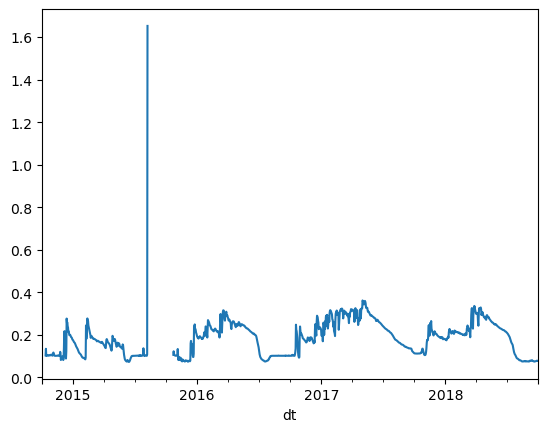

In [52]:
# fig,ax = plt.subplots(2,1, figsize=(8,5.3), sharex=True, sharey=False, layout='constrained',)
sfr_sum_std = sfr_facies_all.groupby(['dt', 'realization']).sum(numeric_only=True).groupby('dt').std()
# (sfr_sum_std['Qaquifer']/sfr_sum_mean['Qaquifer']).plot()
# (sfr_sum_std['Qaquifer']/sfr_sum_mean['Qaquifer']).mean()
(sfr_sum_std['Qrech']/sfr_sum_mean['Qrech']).plot()
(sfr_sum_std['Qrech']/sfr_sum_mean['Qrech']).mean()

# (sfr_sum_std['Qaquifer']).plot()
# sfr_last_std =  sfr_last_all.groupby('dt').std(numeric_only=True)
# (sfr_last_std['Qout']/sfr_last_mean['Qout']).plot(ax=ax[1])
# (sfr_last_std['Qout']).plot(ax=ax[1])

# ax[0].set_yscale('log')
# ax[1].set_yscale('log')


In [53]:
# (sfr_sum_std['Qbase']/sfr_sum_mean['Qbase']).plot()
# (sfr_sum_std['Qbase']/sfr_sum_mean['Qbase']).mean()

## Scatter plots
**Goal**: relate the heterogeneity (e.g., number of coarse bodies connecting to the stream) to the number of days with streamflow.

Need to save data as an aggregated dataframe to run trend analysis

In [159]:
if rewrite:
    t0 = time.time()

    sfr_3mon_all = pd.DataFrame()
    sfr_yr_sum_all = pd.DataFrame()

    for t in np.arange(0,100):
        model_ws = join(all_model_ws, 'realization'+ str(t).zfill(3))
        # clean sfr output
        sfrdf =  clean_sfr_df(model_ws, drop_iseg)
        sfrdf['realization'] = t
        num_coarse = sfrdf['num_coarse'].mean()
        # aggregate to seasonal values, since model starts in october it groups as oct-dec, jan-mar, apr-jun, jul-sep
        sfrdf_mon = sfrdf.resample('3MS').mean(numeric_only=True)
        sfrdf_mon['realization'] = t
        sfrdf_mon['num_coarse'] = num_coarse
        sfr_3mon_all = pd.concat((sfr_3mon_all, sfrdf_mon))
        # aggregate to annual values for each segment
        sfrdf_yr_sum = sfrdf.groupby(['WY','segment']).sum(numeric_only=True)
        sfrdf_yr_sum['realization'] = t
        sfrdf_yr_sum['num_coarse'] = num_coarse
        sfr_yr_sum_all = pd.concat((sfr_yr_sum_all, sfrdf_yr_sum))
    # check time
    t1 = time.time()
    print('Time: %.2f min' % ((t1-t0)/60))

    # save output to speed up reuse
    sfr_3mon_all.to_csv(join(out_dir, 'sfrdf_3month_mean.csv'))
    sfr_yr_sum_all.to_csv(join(out_dir, 'sfrdf_annual_sum_by_segment.csv'))

Time: 6.20 min


In [160]:
# load previously made output to speed up reuse
sfr_3mon_all = pd.read_csv(join(out_dir, 'sfrdf_3month_mean.csv'), parse_dates=['dt'], index_col='dt')
# fix issue where this was averaged
sfr_3mon_all.month = sfr_3mon_all.index.month
sfr_yr_sum_all = pd.read_csv(join(out_dir, 'sfrdf_annual_sum_by_segment.csv'), index_col=['WY','segment'])

In [161]:
# after resampling if need to re-identify the number of coarse in a stream
coarse_ref = sfr_3mon_all.groupby('realization').mean(numeric_only=True)[['num_coarse']]
coarse_ref.to_csv(join(proj_dir, 'num_sfr_coarse.csv'))

In [162]:
from matplotlib import cm

#normalize item number values to colormap
norm = mpl.colors.Normalize(vmin=0, vmax=99)
# plt.cmap='gray'

In [163]:

def plt_wy_seg(value, ylabel, log=False):
    fig,ax = plt.subplots(2,2, figsize=(8,8), sharex=True, sharey=True, layout='constrained')
    wy_unique = sfr_yr_sum_all.index.get_level_values('WY').unique()

    for t in np.arange(0,100):
        sfr_yr_sum = sfr_yr_sum_all[sfr_yr_sum_all.realization==t].reset_index('WY')
        for n,f in enumerate(wy_unique):
            ax_n = ax[int(n/2), n%2]
            df_plt = sfr_yr_sum[sfr_yr_sum.WY==f]
            if df_plt.shape[0]>0:
                df_plt.plot(y=value, ax=ax_n, legend=False, 
                            color='gray',
                            # color=cm.gray(norm(t)),alpha=0.7,
                                         )

    # plot homogeneous case
    h_sfr_yr_sum = h_sfrdf.groupby(['WY', 'segment']).sum(numeric_only=True).reset_index('WY')
    # plot mean of heterogeneous
    sfr_yr_sum_mean = sfr_yr_sum_all.groupby(['WY','segment']).mean().reset_index('WY')
    # set axis labels
    for n,f in enumerate(wy_unique):
        ax_n = ax[int(n/2), n%2]
        h_sfr_yr_sum[h_sfr_yr_sum.WY==f].plot(y=value, ax=ax_n, legend=False, color='black', linestyle='--')
        sfr_yr_sum_mean[sfr_yr_sum_mean.WY==f].plot(y=value, ax=ax_n, legend=False, color='red', linestyle='--')
        ax_n.set_title(f)
        ax_n.set_ylabel(ylabel)
        ax_n.set_xlabel('Segment')
        if log:
            ax_n.set_yscale('log')
#     fig.tight_layout()
#     fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=[0.55, 1.03], ncol = 3)
    fig.legend(handles=legend_elements, loc='outside upper center', ncol = 3)


In [229]:
# grid_sfr_all.groupby('iseg').mean(numeric_only=True).strhc1.plot(label='Mean')
# grid_sfr_all.groupby('iseg').std(numeric_only=True).strhc1.plot(label='Std Dev')
# plt.legend()
# # plt.yscale('log')
# plt.ylabel('Streambed Conductivity ($m/day$)')
# plt.xlabel('Segment')
# there is not a particularly helpful pattern from the mean/median and std devation of the longitudinal strhc1 except some indication of the patch that is consistenly sand/gravel.

Plotting the longitudinal profile for the baseflow, connected days, gaining is not very helpful because there is not a clear way to connect the heterogeneity.  

If we plot baseflow with variable gray scale for each realization we start to see how there is a scattering of baseflow for each realization but it isn't enitrely clear.
- there is still some value in showing the difference from a homogeneous case

A box plot of baseflow by segment is very messy (mostly zeros) means quite a few fliers

If we don't care about presenting the volumes of baseflow so much as the rates than the existence of it so we could do a count of the number of realizations with baseflow?

In [165]:
# fig,ax = plt.subplots()
# for t in np.arange(0,100):
#     sfr_seg = sfr_facies_all[sfr_facies_all.realization==t].groupby('dt').sum(numeric_only=True)
#     sfr_seg.plot(y='Qbase', ax=ax, legend=False, color=cm.gray(norm(t)),alpha=0.7)
# plt.yscale('log')

In [199]:
# sfr_base = sfr_yr_sum_all.groupby(['segment','realization']).mean().reset_index('realization')
# # sfr_base.plot(y='Qbase')
# value='Qbase'
# fig, ax_n = plt.subplots()
# ax_n.set_yscale('log')
# for t in np.arange(0,100):
#     df_plt = sfr_base[sfr_base.realization==t]
#     df_plt.plot(y=value, ax=ax_n, legend=False, 
#                 # color='gray',
#                 color=cm.gray(norm(t)),alpha=0.7,
#                )
   
# # plot homogeneous case
# # h_sfr_yr_sum = h_sfrdf.groupby(['segment']).sum(numeric_only=True).plot(y=value, ax=ax_n, legend=False, color='black', linestyle='--')
# # # plot mean of heterogeneous
# # sfr_yr_sum_mean = sfr_yr_sum_all.groupby(['segment']).mean().plot(y=value, ax=ax_n, legend=False, color='red', linestyle='--')
# plt.xlabel('Segment')
# plt.ylabel('Average Annual Baseflow ($m^3/day$)')

In [207]:

# value = 'Qbase'
# ylabel = 'Baseflow'
# value = 'connected'
# ylabel = 'Connected Days'
# plt_wy_seg(value, ylabel, log=True)
# ax.legend(handles=legend_elements, loc='lower right')


The days with flow drops off at segment 31 because half of the flow becomes over bank flow to the floodplain so less water remains in the channel to recharge near the channel. Then flow returns at segment 51.

The number of connected days is higher with the heterogeneity because there is more groundwater available but what is important is that the number of connected days on average doesn't rise above 150-250 on average while days with flow is ideally much closer to 365 (in wet years this happens). So although we see more days of connection with baseflow overall the system loses water sooner than in a homogeneous case.

Also the key conversation between longitudinal days with flow and streamflow at the outlet over time is that by the last segment we see the cumulative effect of the baseflow while intermediate segments may see more or less flow due to high seepage rates and the floodplain.

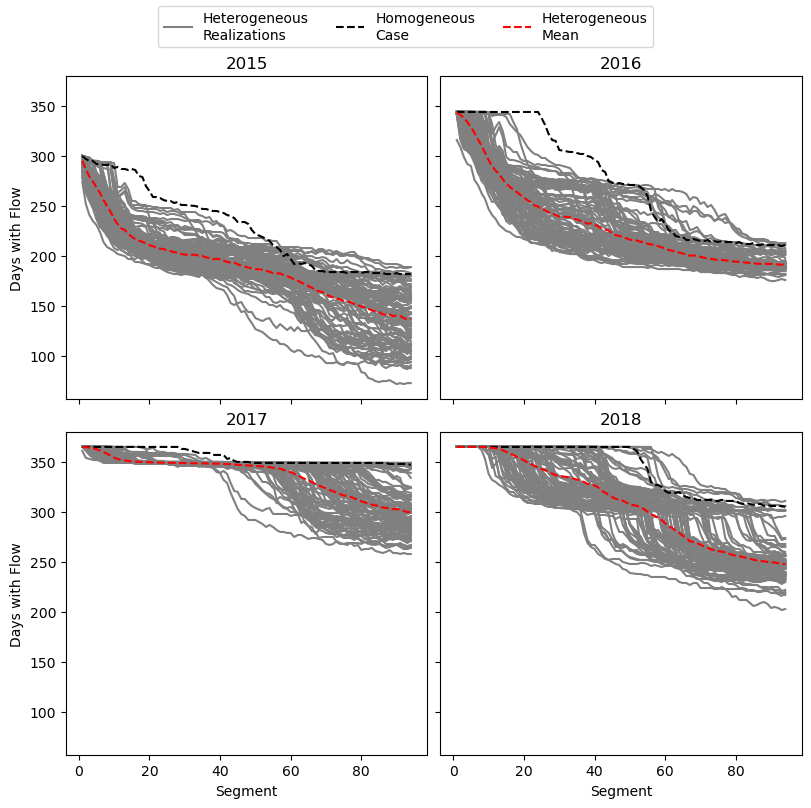

In [212]:
value = 'flowing'
ylabel = 'Days with Flow'
plt_wy_seg(value, ylabel)
plt.savefig(join(fig_dir, 'days_with_flow_by_WY.png'), bbox_inches='tight')

In [64]:
# sfr_yr_sum_all.groupby(['segment']).std(numeric_only=True).plot(y='flowing')
# sns.relplot(sfr_yr_sum_all.groupby(['WY','segment']).std(numeric_only=True), x = 'segment',y='flowing', col='WY', col_wrap=2)

All WY have a fairly tight start (low variance) because the flow at the inlet is least impacted yet by differences in geology. In low flow years we don't see a signal from the floodplain connection but rather we see a fairly consistent decline across all realizations in days with flow with the largest variablility toward the outlet. In WY2016 there is a pattern where the peak variability occurs just before the floodplain diversion, which might be explained by the floodplain distributing water for recharge such that it provides a reduction in seepage rates out of the stream, this pattern might be stronger here because 2016 starts with initially dry streamflow conditions. The WY2016 reduction in standard deviation below the floodplain diversion might also be explained by the fact that less water in the channel means less seepage so the channel might be more uniformly dry  

IN WY2017 we see lower variability in the upper reaches because there is so much flow available that even seepage from the coarse facies can't drain it all, but as we get downstream we start to see more variability as the cumulative effect of coarse segments occurs and this is likely impact by the floodplain return flows having more variability. 

In [65]:
# need to see why water could be leaving the lake in a few scenarios
# g = sns.relplot(sfr_yr_sum_all, x='segment',y='flowing', col='WY', col_wrap=2, hue='realization', #color='gray', 
#            facet_kws={'sharey': False, 'sharex': True})



In [196]:
# import seaborn as sns

# g = sns.relplot(sfrdf_all, x='num_coarse',y='Qbase', col= 'month', row='WY', color='gray', 
           # facet_kws={'sharey': False, 'sharex': True})



# Statistics
1. Present overview of all parts of the streamflow system that could be reasonably impacted by heterogeneity, streamflow, streambed recharge, stream baseflow, days with flow, stream-aquifer connectivity and maybe gradient. Present on aggregate basis or annual basis with just the correlation values.  

2. Present the streamflow components with high correlation values on a seasonal and annual basis to show how heterogeneity plays a larger role at different times of the year.

- For streamflow the annual sum or mean should only be taken on the last segment to look at cumulative effects.
- For streambed recharge and baseflow the annual sum across all segments should be used with either the sum or mean across all days.
- For stream-aquifer connectivity it would need to be the mean across all segments and the sum across all days. The gaining losing relationship is equal and opposite so only use gaining.

Is it worth looking at how the correlation is on a daily scale?

- Pearson's r absolute value: .5 to 1 is strong, .3 to .5 is moderate, 0 to .3 is weak
    - italicize r, no leading zero as maximum is 1, two significant digits is common, if reporting significance of the test then also report degrees of freedom (sample size - 2)   
- Spearman's coefficient is defined as the Pearson coefficient between the rank variables. X, Y are converted to ranks R(X), R(Y) then pearson's r is calculated.
- Kendall's tau is a test on whether the order of the variables aligns with the values, that is xi > xj and yi > yj to be considered concordant. The statistics then is based on the number of concordant and discordant pairs.

In [169]:
# the connected and gaining variables are interesting from a box plot perspective but the correlations tend to be insignificant or NAs
variables = {'Qbase':'Baseflow','Qrech':'Recharge', 'flowing':'Flowing',
             # 'connected':'Connected', 'gaining':'Gaining',
            'Qout':'Streamflow'}
tests = ['Pearson','Spearman','Kendall']
var_names = list(variables.keys())

In [171]:
# ref_out = pd.read_csv(join(proj_dir, 'coarse_reference.csv'), index_col=0)
ref_out = pd.read_csv(join(proj_dir, 'num_sfr_coarse.csv'), index_col=0)
ref_out=ref_out.rename(columns={'num_coarse':'num_sfr'})

## Correlations for all time

In [172]:
# the data is already summed across the year and should be averaged across segments
corr_bool = sfr_yr_sum_all.groupby(['realization', 'segment']).sum().groupby('realization').mean()
corr_bool = corr_bool[['flowing','connected','gaining']]
# seepage data just needs to be summed again 
corr_seep = sfr_yr_sum_all.groupby('realization').sum(numeric_only=True)[['Qbase','Qrech']]
# flow data should be averaged
# i tried log10 transform but was problematic with zeros and replacement value, also had lower correlation
corr_flow = sfr_last_all[['realization','Qout']]
corr_flow = corr_flow.groupby('realization').mean(numeric_only=True)[['Qout']]

# join together the data for correlations
corr_all = corr_seep.join(corr_bool).join(corr_flow)

corr_all = corr_all[var_names]

In [175]:
def calc_corr_stats(corr_all, coarse_ref):
    # take pearson's r
    pr = corr_all.apply(lambda x : pearsonr(coarse_ref, x), axis=0)
    pr.index=['r','p']
    pr['type'] = 'Pearson'
    sr = corr_all.apply(lambda x : spearmanr(coarse_ref, x), axis=0)
    sr.index=['r','p']
    sr['type'] = 'Spearman'
    kt = corr_all.apply(lambda x : kendalltau(coarse_ref, x), axis=0)
    kt.index=['r','p']
    kt['type'] = 'Kendall'
    # join data together
    corr_out = pd.concat((pr, sr, kt))
    return(corr_out)
corr_out = calc_corr_stats(corr_all, coarse_ref.num_coarse)
# corr_out = calc_corr_stats(corr_all, ref_out.num_sfr.values)
# corr_out = calc_corr_stats(corr_all, ref_out.num_lak.values)
# corr_out = corr_out[[var_names+['type']]]

# the applicability of certain variables is questionable since Qrech, flowing, Qout have median
# p values of > 0.05
corr_out.loc['p']


,Qbase,Qrech,flowing,Qout,type
p,3.492328e-05,5.534933e-09,2.008035e-12,4.888393e-10,Pearson
p,1.295580e-09,2.121910e-09,3.823855e-12,5.423889e-11,Spearman
p,1.124792e-08,5.161036e-09,2.079981e-11,2.172975e-10,Kendall


The correlations are all below 0.15 when looking at the number of coarse lake segments.


Text(0, 0.5, 'Correlation Coefficient')

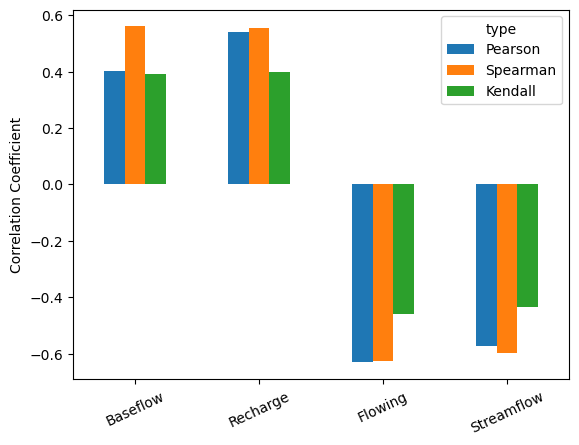

In [176]:
fig, ax = plt.subplots()
# prepare for plotting
corr_out = corr_out.loc['r'].set_index('type').transpose()

corr_out.plot(kind='bar', ax=ax, rot=25)
# fix column names
ax.set_xticks(ticks = np.arange(0,corr_all.shape[1]), labels = [variables[v] for v in corr_all.columns.values])
plt.ylabel('Correlation Coefficient')
# ax.xticks

## Correlations grouped by water year
Did I take these numbers from SASb GSP or from Rich?
|WY |Types|WYsum|
|:----|:---------------|-----|
|2015 | Critical|9.23|
|2016 | Below Normal|17.47|
|2017 | Wet|37.82|
|2018 | Below Normal|12.86|

I recalculated these with the Fair Oaks station and found 15.2, 17.2, 37 and 23 inches of rainfall each Water Year

In [177]:
# yearly
# the data is already summed across the year and should be averaged across segments
# corr_bool = sfr_yr_sum_all.groupby(['realization', 'WY']).mean()
# corr_bool = corr_bool[['flowing','connected','gaining']]
# # seepage data just needs to be summed again 
# corr_seep = sfr_yr_sum_all.groupby(['realization', 'WY']).sum(numeric_only=True)[['Qbase','Qrech']]
# # flow data should be averaged
# corr_flow = sfr_last_all.groupby(['realization','WY']).mean(numeric_only=True)[['Qout']]
# # join together the data for correlations
# corr_all = corr_seep.join(corr_bool).join(corr_flow).reset_index('WY')

In [178]:
# corr_out = pd.DataFrame()
# for n_wy in wy_vals:
# # corr_all.groupby('WY').apply(lambda x : pearsonr(coarse_ref.num_coarse, x))
#     corr_wy = corr_all[corr_all.WY==n_wy].drop(columns=['WY'])
#     corr_out = pd.concat((corr_out, calc_corr_stats(corr_wy, coarse_ref.num_coarse).assign(WY=n_wy)))
    

In [179]:
# the applicability of certain variables is questionable since Qrech, flowing, Qout have median
# p values of > 0.05
# corr_out.loc['p']

In [180]:
# fig, ax = plt.subplots(3,2, figsize=(8,5.3), sharex=True, sharey=True, layout='constrained')
# for n, v in enumerate(variables.keys()):
#     ax_n = ax[int(n/2), n%2]
#     corr_plt = corr_out.loc['r'][[v,'type','WY']].pivot_table(index='WY', values=v, columns='type')
#     # correct order of tests which were resorted
#     corr_plt[tests].plot(kind='bar', ax=ax_n, legend=False, rot=0)
#     ax_n.set_title(variables[v])
# ax[0,1].legend(loc='best')


When aggregated to a yearly level the correlations don't really change between water years.

## Correlations grouped by season and year
Need to be careful with p-values because the plots with low correlations tend to have p-values greater than 0.05 and the plots with no correlation occur when the value is constant for all realizations (e.g., no baseflow or flow in any realization in WY2015 month 7).

In [181]:
# yearly
# the data is already summed across the year and should be averaged across segments
corr_bool = sfr_3mon_all.copy().set_index('realization',append=True)[['flowing','connected','gaining']]
# sum across all segments for seepage
corr_seep = sfr_facies_all.groupby('realization').resample('3MS').sum(numeric_only=True)[['Qbase','Qrech']]
# flow data should be averaged
corr_flow = sfr_last_all.groupby(['realization']).resample('3MS').mean(numeric_only=True)[['Qout']]
# join together the data for correlations
corr_all = corr_seep.join(corr_bool).join(corr_flow).reset_index('dt')

In [182]:
corr_all['month'] = corr_all.dt.dt.month
corr_all['wy'] = corr_all.dt.dt.year
corr_all.loc[corr_all.month==10,'wy'] +=1

corr_all = corr_all[var_names+['dt','month','wy']]


In [183]:
corr_out = pd.DataFrame()
for n_dt in corr_all.dt.unique():
# corr_all.groupby('WY').apply(lambda x : pearsonr(coarse_ref.num_coarse, x))
    corr_dt = corr_all[corr_all.dt==n_dt].drop(columns=['dt'])
    corr_out = pd.concat((corr_out, calc_corr_stats(corr_dt, coarse_ref.num_coarse).assign(dt=n_dt)))
corr_out['month'] = corr_out.dt.dt.month
corr_out['wy'] = corr_out.dt.dt.year
corr_out.loc[corr_out.month==10,'wy'] +=1
corr_out = corr_out.drop(columns=['dt'])   

In [184]:
# there are NA values prodcued in some cases during the winter, only for flowing variable
# the NAs occur because in 2016 every realization had 100% of days in winter,spring with flow so there is
# no relationship at all

In [185]:
# the applicability of certain variables is questionable since Qrech, flowing, Qout have median
# p values of > 0.05
# corr_out.loc['p']
# corr_out.loc['p',variables.keys()][corr_out.loc['p', variables.keys()]>0.05]
# corr_out
pval_large = corr_out.loc['p'][(corr_out.loc['p', var_names]>0.05).any(axis=1).values]
pval_large[pval_large[var_names]<0.05] = np.nan
pval_large

,Qbase,Qrech,flowing,Qout,month,wy,type
p,0.061096,NaN,NaN,NaN,10,2015,Pearson
p,0.224235,NaN,NaN,NaN,4,2015,Pearson
p,0.070817,NaN,NaN,NaN,4,2015,Spearman
p,0.071401,NaN,NaN,NaN,4,2015,Kendall
p,NaN,0.192996,NaN,NaN,7,2015,Pearson
p,NaN,0.118459,NaN,NaN,7,2016,Pearson
p,NaN,0.136426,NaN,NaN,7,2016,Spearman
p,NaN,0.189707,NaN,NaN,7,2016,Kendall
p,0.337069,NaN,NaN,NaN,7,2017,Pearson
p,0.065416,NaN,NaN,NaN,7,2017,Spearman


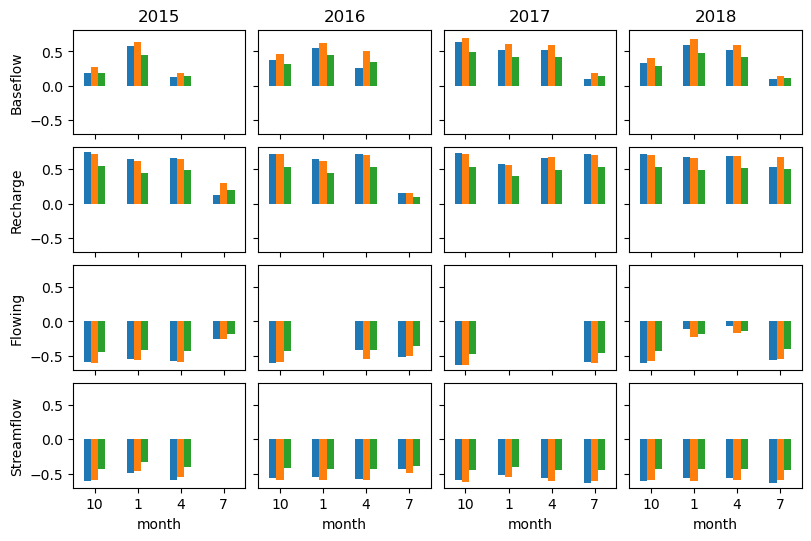

In [223]:
fig, ax = plt.subplots(len(var_names),4, figsize=(8,5.3), sharex=True, sharey=True, layout='constrained')
for nv, v in enumerate(variables.keys()): #['Qbase','Qout']
    corr_plt = corr_out.loc['r'][[v,'type','wy','month']] 
    for nwy, wy in enumerate(corr_plt.wy.unique()):
        ax_n = ax[nv, nwy]
        corr_wy = corr_plt[corr_plt.wy==wy].drop(columns=['wy']).pivot_table(index='month', values=v, 
                                                                             columns='type', dropna=False)
        # correct order of tests and months to fix sorting
        corr_wy[tests].loc[corr_out.month.unique()].plot(kind='bar', ax=ax_n, legend=False, rot=0)
        ax_n.set_ylabel(variables[v])
for nwy, wy in enumerate(corr_plt.wy.unique()):
    ax_n = ax[0, nwy]
    ax_n.set_title(wy)
#     ax_n.set_xticks(ticks = np.arange(0,corr_mon.shape[0]), labels = corr_out.month.unique())


# ax[0,1].legend(loc='best')
plt.savefig(join(fig_dir, 'corr_stats_season_WY.png'), bbox_inches='tight')

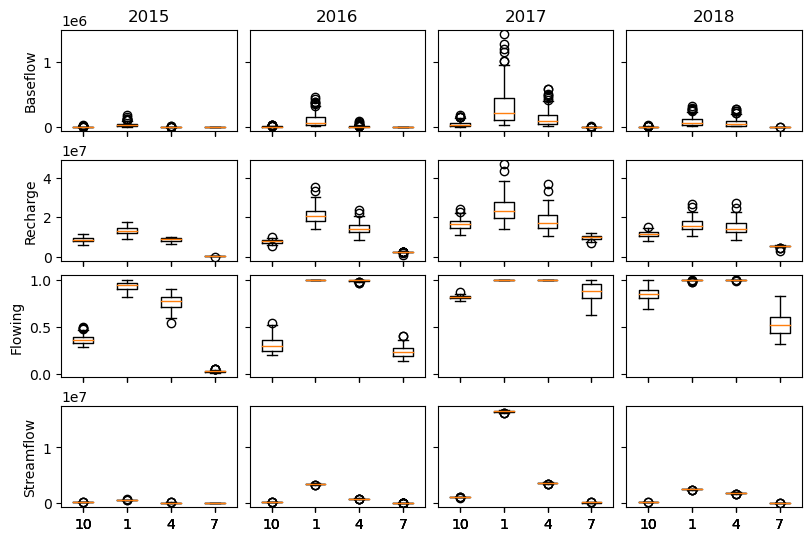

In [224]:
# goal is to present the data used to calculate the correlations in box plot format
# box plot can't seem to handle the xtick formatting and throws an error even though there should only be 4 xticks, it thinks tehre are 8
m_cols=[10,1,4,7]
# m_cols = corr_all.month.unique()
fig, ax = plt.subplots(len(var_names),4, figsize=(8,5.3), sharex='col', sharey='row', layout='constrained')
for nv, v in enumerate(variables.keys()): #['Qbase','Qout']
    corr_plt = corr_all[[v,'wy','month']] 
    ax[nv, 0].set_ylabel(variables[v])

    for nwy, wy in enumerate(corr_plt.wy.unique()):
        ax_n = ax[nv, nwy]
        corr_wy = corr_plt[corr_plt.wy==wy].drop(columns=['wy']).pivot(columns='month', values=v)
        corr_wy = corr_wy.reset_index(drop=True).rename_axis(None,axis=1).loc[:, m_cols]

        # # correct order of tests and months to fix sorting
        # corr_wy.plot(column=m_cols, kind='box', ax=ax_n, legend=False, rot=0)
        # corr_plt[corr_plt.wy==2015].plot(by='month', column=v, kind='box', ax=ax_n)
        ax_n.boxplot(corr_wy.values, labels=m_cols);
        # ax_n.set(xticklabels=m_cols)

for nwy, wy in enumerate(corr_plt.wy.unique()):
    ax_n = ax[0, nwy]
    ax_n.set_title(wy)

# ax[0,0].set_yscale('log')
# ax[1,0].set_yscale('log')
# ax[-1,0].set_yscale('log')
# ax[-1,0].locator_params(axis='y', nbins=3) # can't specify number of bins with log scale
# ax[0,0].ticklabel_format(style='plain')
plt.savefig(join(fig_dir, 'Appendix', 'corr_boxplots_season_WY.png'), bbox_inches='tight')

A lot of good discussion could come from the correlation by year and season figure. FOr example:
- the flowing variable shows much stronger correlations in the dry season in wet and above normal years because the coarser facies are having a proportionally larger impact when there is less flow in the river. And the correlation is signficiant in all seasons in a critical year because there was such limited streamflow in the winter that the seepage due to the streambed had a larger effect. 
- For the streambed recharge the correlation is equally strong in season in the wet and above normal year because there is sufficient flow available to make sure of the coarser facies for recharge. While the critical and below normal year see a less signficiant correlation in the summer months because there is not enough water in the stream for the number of coarse facies to make an impact since the stream goes dry.
- the baseflow has a similar pattern as streambed recharge with a greater tendency to see weaker correlations when there is less water available because the groundwater elevations have already lowered such that there is no possibility of baseflow. This is most significant in the critical year when there is no correlation in spring because there isn't enough water for the coarse facies to recharge during storm events to make it available afterward for baseflow. This is where we start to see that the coarse facies provide baseflow benefits only if there is sufficiently large flow available. And we see that the correlations does not happen in the dry season.

The correlations by year and season help identify that the coarse deposits consistently increase streambed leakage and decrease streamflow availability in all years and seasons, with the exception of summer 2015 when the channel went dry. The baseflow correlation shows that benefits do not occur in the dry season, and are limited to winter months in non-critical years with very limited benefits in the peak wet season for a critical year.

### Questions on correlations
How did you find these three correlative statistics?
I noticed you adjusted for normallity for Pearson's r with the variable and predictor? Was that determined by looking at the distribution of the variable for the 100 sites? In my case I have 100 realizations
How did you find the actual value of the statistic relevant? I'm considering primarily looking at the comparison between statistics to show where correlation is stronger?

Pearson's r requires normality, Steve applied log10 transformation selectively on variables and predictors to improve normality. Spearman's rho and Kendall's tau. In this case the variable is the number of coarse stream segments, the histogram shows it sort of normally distributed with a slight peak around 30, but the data has lots of highs and lows probably because I'm plotting the number of segments with coarse and not necessarily the number of coarse bodies connecting to the stream.

- Graham suggested to show the linearity of the data in the model appendix. These plots can be saved then imported all at once to a word document.

In [208]:
coarse_ref.quantile([0,.5,1])*100/91

,num_coarse
0.0,5.494505
0.5,35.164835
1.0,78.021978


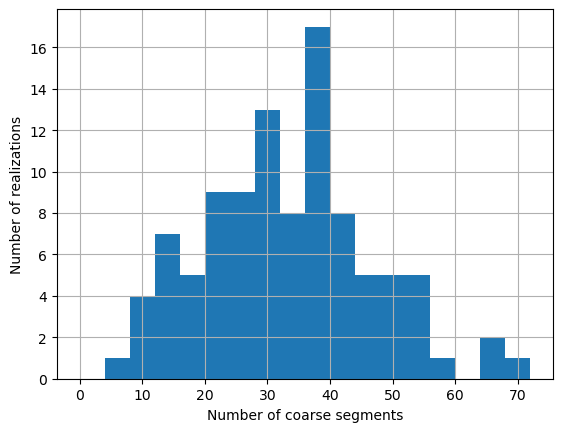

In [228]:
bins = len(coarse_ref.num_coarse.unique())
coarse_ref.hist('num_coarse',
                # bins = bins
                bins= np.arange(0, int(coarse_ref.max().values[0])+4, 4) # group with bins of size 4 to account for downscaling from 200 m to 100m gri dcell
               )
plt.xlabel('Number of coarse segments')
plt.ylabel('Number of realizations')
plt.title(None)
plt.savefig(join(fig_dir, 'coarse_segments_SFR_histogram.png'), dpi=300, bbox_inches='tight')

In [218]:
# exampel regression
plt_month = sfr_3mon_all[sfr_3mon_all.month==1]
df_plt = plt_month[plt_month.WY==2017]
# ax = df_plt.plot(x='num_coarse',y='Qbase', kind='scatter', color='gray')

# regr = linear_model.LinearRegression()
# regr.fit(df_plt[['num_coarse']].values, df_plt[['Qbase']].values)
# x_range = np.array([[df_plt.num_coarse.min()], [df_plt.num_coarse.max()]])
# ax.plot(x_range, regr.predict(x_range), color='black', linewidth=3)
# r2_val = r2_score(df_plt[['Qbase']], regr.predict(df_plt[['num_coarse']].values))
# ax.annotate('$r^2$: '+ str(np.round(r2_val,3)), (0.85,0.85), xycoords='axes fraction')

In [219]:
def corr_plt_seep(name, ylabel):
    """ name is Qbase or Qrech"""
    fig,ax = plt.subplots(4,4, figsize=(8,5.3), sharex=True, sharey=False, layout='constrained')
    # plot of number of connected days across realizations
    # plot across years in rows
    for yn, wy in enumerate(plt_month.WY.unique()):
        df_wy = sfr_3mon_all[sfr_3mon_all.WY==wy]
        # plot across 3 month blocks in columns
        for mn, mon in enumerate(sfr_3mon_all.month.unique()):
            df_plt = df_wy[df_wy.month==mon]
            ax_n = ax[yn, mn]
            df_plt.plot(x='num_coarse',y=name, kind='scatter', color='gray', ax = ax_n)
            # linear, regression
#             sns.regplot(x='num_coarse', y=name,data=df_plt,ci=False,ax=ax_n, label='Linear Model', scatter=False)
            regr = linear_model.LinearRegression()
            regr.fit(df_plt[['num_coarse']].values, df_plt[[name]].values)
            x_range = np.array([[df_plt.num_coarse.min()], [df_plt.num_coarse.max()]])
            ax_n.plot(x_range, regr.predict(x_range), color='black', linewidth=3)
            r2_val = r2_score(df_plt[[name]], regr.predict(df_plt[['num_coarse']].values))
            ax_n.annotate('$r^2$: '+ str(np.round(r2_val,3)), (0.1,0.8), xycoords='axes fraction')
            # plot clean up
            ax_n.set_ylabel('')
            ax_n.set_xlabel('')

    for yn, wy in enumerate(plt_month.WY.unique().astype(int)):
        ax_n = ax[yn, 0]
        ax_n.set_ylabel(str(wy))
    labels_3mon = ['Oct-Dec','Jan-Mar','Apr-Jun','Jul-Sep']
    for mn, mon in enumerate(sfr_3mon_all.month.unique()):
        ax_n = ax[0, mn]
        ax_n.set_title(labels_3mon[mn])
    fig.text(-0.01, 0.4, 'Mean Seasonal '+ylabel, rotation=90)
    fig.text(0.4, -0.01, 'Number of Coarse Stream Segments')

    fig.tight_layout()

C:\Users\ajcalder\AppData\Local\Temp\ipykernel_111652\3313486803.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_111652\3313486803.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_111652\3313486803.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_111652\3313486803.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


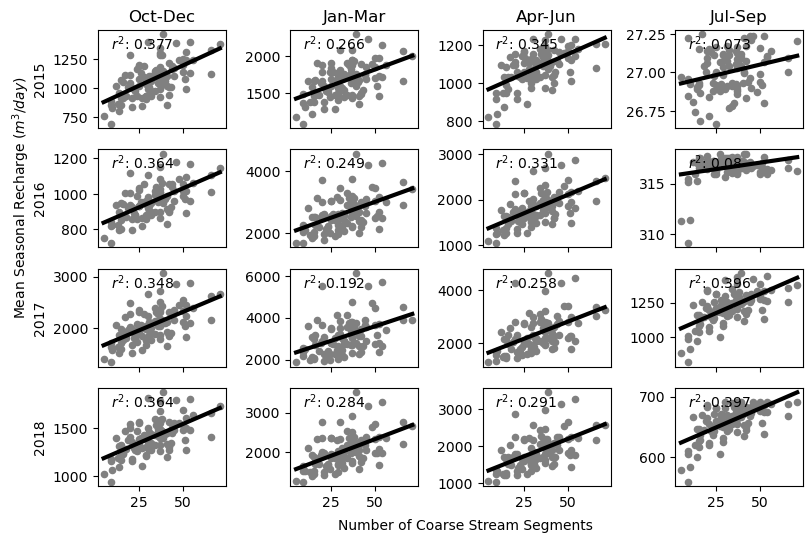

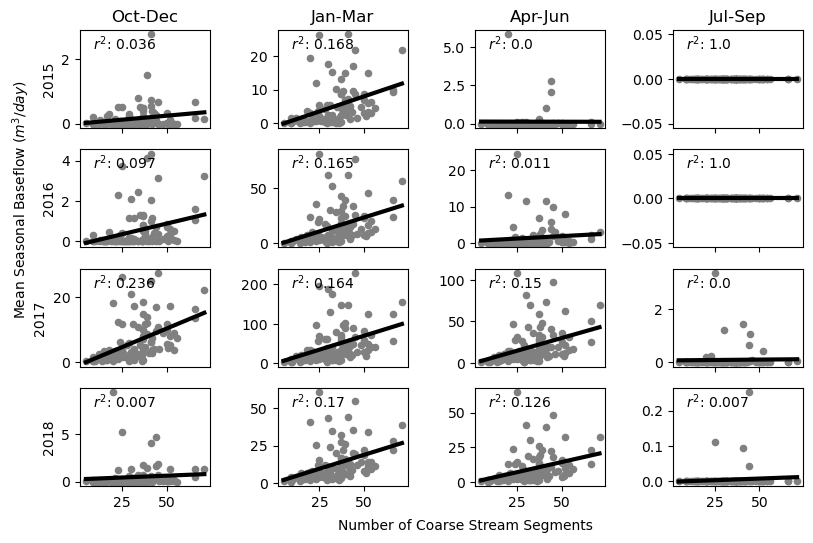

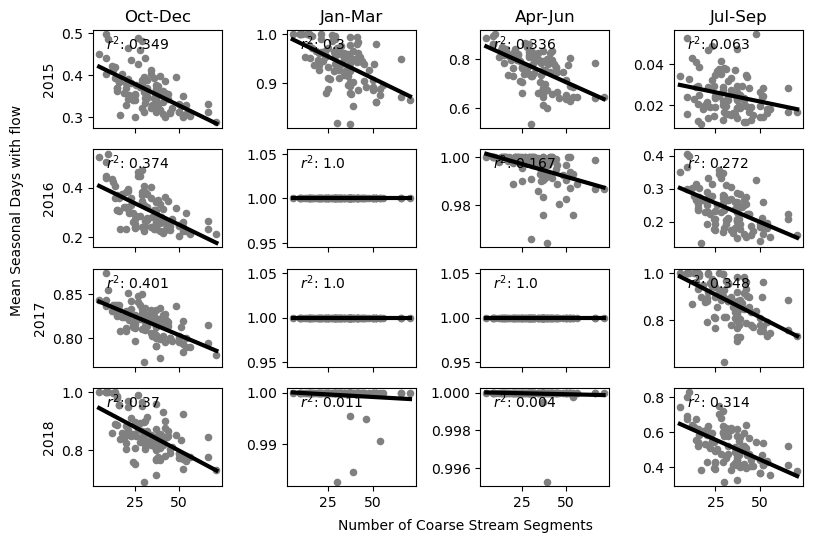

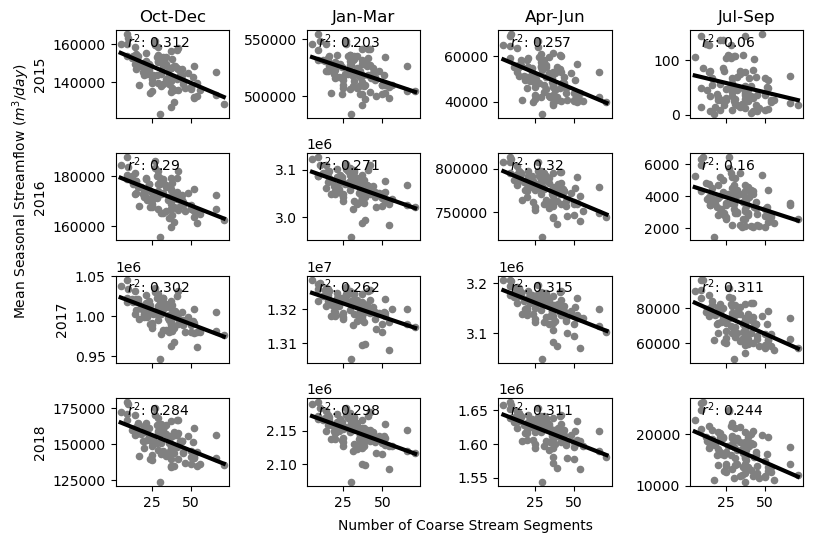

In [222]:
labels=['Recharge ($m^3/day$)','Baseflow ($m^3/day$)','Days with flow','Streamflow ($m^3/day$)']
for n, param in enumerate(['Qrech','Qbase', 'flowing', 'Qout']):
    corr_plt_seep(param, labels[n])

    plt.savefig(join(fig_dir, 'corr_scatter_'+param+'.png'), bbox_inches='tight')

# Application figure
Summary of net change in baseflow and ET for all realizations compared to the homogeneous case.

And importantly, how does this change baseflow in seasons of concern, regarding the cosumnes functional flow regime. Between the homogeneous and hetergeneous realizations we need to sum across all segments because it's not fair to compare individual segments with the heterogeneity. But each day is a valuable comparison because a lack of flow is potential harmful to up-migrating salmon especially in fall.

Although the number of days with flow doesn't have a significant relationship with heterogeneity I can still present the results holistically.



In [ ]:
# sfr_facies_all
# sum for the seepage
total_flow = sfr_facies_all.groupby('realization').resample('3MS').sum(numeric_only=True)[['Qbase']]
total_flow = total_flow.reset_index('realization')

# homogeneous case
h_flow = h_sfrdf.resample('3MS').sum(numeric_only=True)[['Qbase']]
h_conn = h_sfrdf.resample('3MS').mean(numeric_only=True)[['flowing']]

In [ ]:
nseg = sfrdf.segment.unique().shape[0]
# average for days of connection (facies are already summed so sum together then divide by number of segments)
# now it is the fraction of the segments with flow
total_conn = sfr_facies_all.groupby(['realization', 'dt']).sum(numeric_only=True)[['flowing']]/nseg
total_conn = total_conn.reset_index('realization')
# can calculate the fraction of a season with flow
total_conn = total_conn.groupby('realization').resample('3MS').mean().reset_index('realization', drop=True)

Similar to the plot showing days with flow by segment, the overall number of days with flow doesn't change much when looking at the histogram. From the earlier plots it looked like flow was extended at the downstream longer while reduced at the upstream. To show how downstream conditions change, we should represent the flow by requiring all segments to be flowing, take minimum of all segments which would essentially be the same as taking the most downstream segment. 

In [ ]:
plt_date = '2015-10-1'
total_conn[total_conn.index==plt_date].hist('flowing')
plt.axvline(h_conn[h_conn.index==plt_date].flowing[0],color='red')

#plot(x='realization',y='flowing',kind='scatter')

In [ ]:
total_flow = total_flow.join(h_flow,rsuffix='_h')
total_flow['Qbase_diff'] = total_flow.Qbase - total_flow.Qbase_h

In [ ]:
total_flow_fall = total_flow[total_flow.index.month==10]
fig, ax = plt.subplots(2,2)
for n, y in enumerate(total_flow_fall.index.unique()):
    ax_n = ax[int(n/2), n%2]
    sns.histplot(total_flow_fall[total_flow_fall.index==y], x='Qbase_diff', ax=ax_n,bins=10)

## Last segment comparison
Show plot of how the number of days of flow averaged doesn't change much from the homogeneous case, but the days with flow at the outlet are more noticeable.
- based on Graham's recommendation we will see variability above and below the homogeneous case with the heterogeneous realizations, but what is likely more interesting is  showing for an individual realization why the flows were different. We still should provide some variability numbers for managers to understand why heterogeneity in reality might shift from the modeling of a homogeneous case.

In [ ]:
# groupby season and year
total_last = sfr_last_all.groupby('realization', group_keys=False).resample('3MS').mean(numeric_only=True)
h_last = h_sfrdf[h_sfrdf.segment==h_sfrdf.segment.max()]
h_last = h_last.resample('3MS').mean(numeric_only=True)


In [ ]:
total_last.columns

In [ ]:
# we want to give something easy to digest so like a yes or no, or the number of realizations each season
# that are better than the homogeneous case
# total_last['month'] = total_last.index.get_level_values('dt').month
# total_last.groupby(['realization','month']).mean()

In [ ]:
# total_[['Qout']]

In [ ]:
# calculate difference in flow from base case
total_last['Qout_diff'] = (total_last[['Qout']] - h_last[['Qout']]).values
total_last['flowing_diff'] = (total_last[['flowing']] - h_last[['flowing']]).values
# get values for fall only
total_last_fall = total_last[total_last.index.month==10]


Does it make sense to give a simple response such as this many realization provided more water or the volume difference average.

In [ ]:
for n, n_y in enumerate(total_last_fall.index.year.unique()):
    more_flow = (total_last_fall[total_last_fall.index.year==n_y].flowing_diff>=0)
    more_flow = (total_last_fall[total_last_fall.index.year==n_y].Qout_diff>=0)

    print(n_y+1, more_flow.sum())

In [ ]:
plt_date = '2017-10-1'

total_last[total_last.index==plt_date].hist('flowing')
plt.axvline(h_last[h_last.index==plt_date].flowing[0],color='red')
